In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sn
import pathlib
import os
from os import listdir
import glob
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    LayerNormalization,
    AveragePooling2D,
    Normalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cinic_directory_train = 'D:\\GitHub\\CINIC-10\\train'
cinic_directory_test = 'D:\\GitHub\\CINIC-10\\test' 
cinic_directory_val = 'D:\\GitHub\\CINIC-10\\valid'

SEED = 1337

tf.random.set_seed(SEED)

optimiser='adamax'
nb_epochs=20
batch_size_choice=16
image_size=(32, 32)
loss_func='categorical_crossentropy'
#metrics=['categorical_accuracy','AUC','Precision','Recall',tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5, average='weighted')] 

c:\Users\kraft\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\kraft\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

# Funkcje pomocnicze

In [2]:
def show_training_validation_loss_and_metrics(model,metrics):
    f,ax=plt.subplots(2,1,figsize=(20,20)) 

    #Assigning the first subplot to graph training loss and validation loss
    ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
    ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

    #Plotting the training accuracy and validation accuracy
    for metric in metrics:
        ax[1].plot(model.history.history[metric],label='Training '+metric)
        ax[1].plot(model.history.history['val_'+metric],label='Validation '+metric)

    plt.legend() 

In [3]:
def show_confusion_matrix(model, test_ds, num_classes, class_names):
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    tf_labels = tf.argmax(true_labels, axis=1).numpy()

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=num_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy(), display_labels=class_names)
    fig, ax = plt.subplots(figsize=(11, 9))  # Ustaw rozmiar wykresu na 10x8

    # Wyświetl macierz pomyłek z określonym rozmiarem
    disp.plot(ax=ax)  # Użyj parametru ax, aby użyć określonej osi
    plt.show()
    return

In [4]:
def show_confusion_matrix_without_names(model, test_ds, num_classes):
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    tf_labels = tf.argmax(true_labels, axis=1).numpy()

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=num_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy())
    fig, ax = plt.subplots(figsize=(11, 9))  # Ustaw rozmiar wykresu na 10x8

    # Wyświetl macierz pomyłek z określonym rozmiarem
    disp.plot(ax=ax)  # Użyj parametru ax, aby użyć określonej osi
    plt.show()
    return

# Wczytanie danych

In [5]:
# loading in the data 
train_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_train,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [6]:
# loading in the data 
validation_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_val,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [7]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_test,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [8]:
class_names= train_ds.class_names
num_classes = len(class_names)

print(class_names)

metrics=['categorical_accuracy','AUC','Precision','Recall',tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5, average='weighted')]
metrics2 = ['categorical_accuracy','auc','precision','recall', 'f1_score']

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
# Normalize all data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    brightness_range = [0.9,1.1],
    channel_shift_range = 50
    )
datagen_valid = ImageDataGenerator(rescale=1./255)

In [12]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    cinic_directory_train,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    cinic_directory_val,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
test_it = datagen_valid.flow_from_directory(
    cinic_directory_test,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


In [13]:
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False)

In [14]:
# Freeze base model
base_model.trainable = False

In [15]:
# Create inputs with correct shape
inputs = keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalMaxPooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs,outputs)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 5,130
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
model.compile(loss='categorical_crossentropy', metrics=metrics)

In [18]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_ds,
          validation_data=validation_ds,
          epochs=nb_epochs,
          callbacks=[callback]
        )

Epoch 1/20


5625/5625 [==============================] - 86s 14ms/step - loss: 1.6404 - categorical_accuracy: 0.4228 - auc: 0.8404 - precision: 0.6524 - recall: 0.1599 - f1_score: 0.2430 - val_loss: 1.5524 - val_categorical_accuracy: 0.4560 - val_auc: 0.8595 - val_precision: 0.6563 - val_recall: 0.2173 - val_f1_score: 0.3127
Epoch 2/20
5625/5625 [==============================] - 78s 14ms/step - loss: 1.5332 - categorical_accuracy: 0.4642 - auc: 0.8635 - precision: 0.6527 - recall: 0.2454 - f1_score: 0.3407 - val_loss: 1.5335 - val_categorical_accuracy: 0.4671 - val_auc: 0.8644 - val_precision: 0.6487 - val_recall: 0.2524 - val_f1_score: 0.3488
Epoch 3/20
5625/5625 [==============================] - 78s 14ms/step - loss: 1.5178 - categorical_accuracy: 0.4736 - auc: 0.8674 - precision: 0.6489 - recall: 0.2700 - f1_score: 0.3657 - val_loss: 1.5285 - val_categorical_accuracy: 0.4723 - val_auc: 0.8664 - val_precision: 0.6444 - val_recall: 0.2719 - val_f1_score: 0.3687
Epoch 4/20
5625/5625 [===========

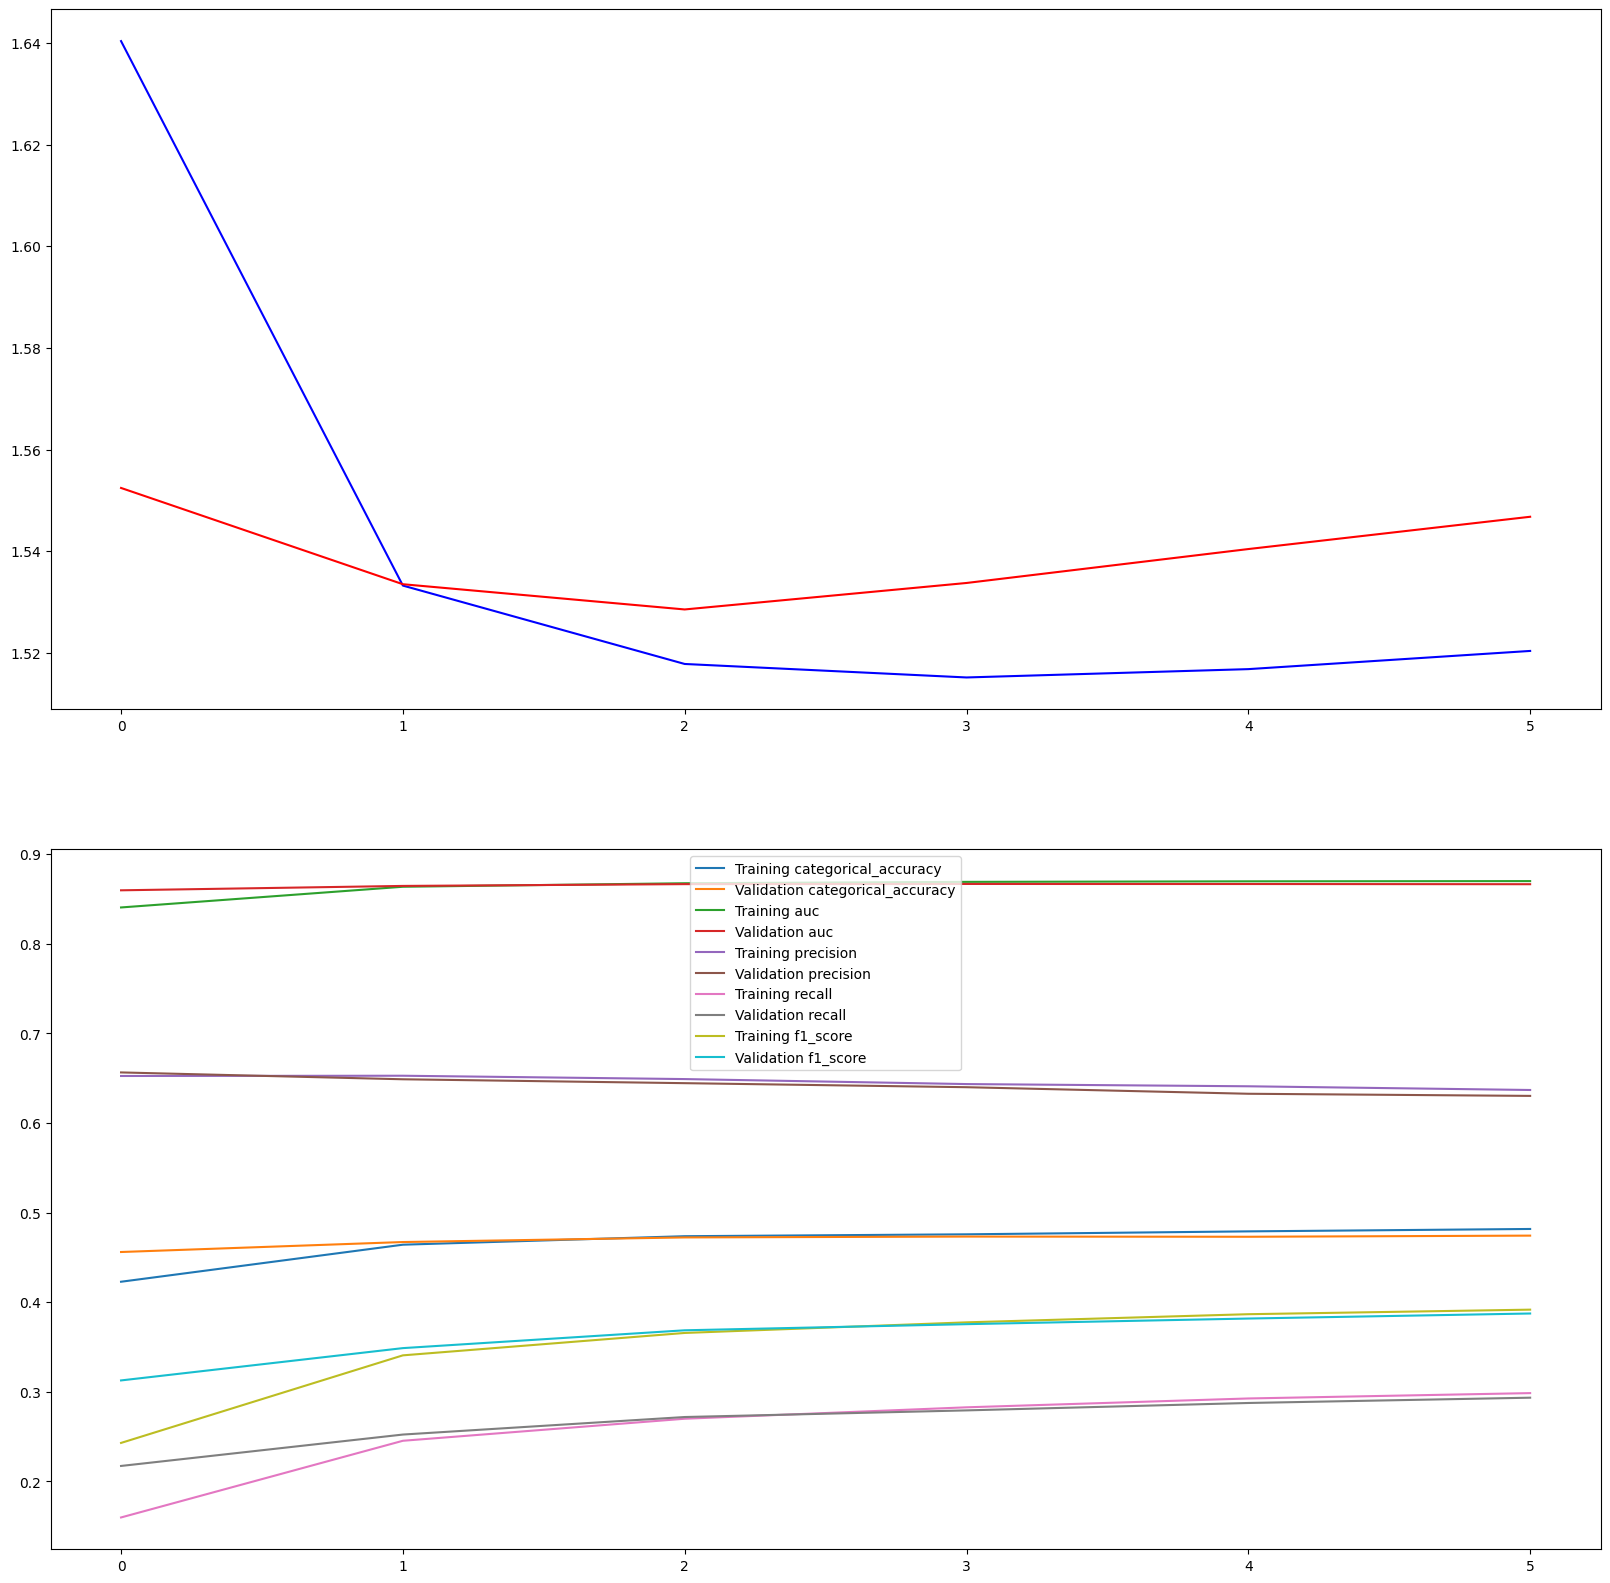

In [19]:
show_training_validation_loss_and_metrics(model,metrics2) 

In [20]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate = .00001),
              loss = 'categorical_crossentropy' , metrics = metrics)

In [21]:
#callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_ds,
          validation_data=validation_ds,
          epochs=nb_epochs,
          callbacks=[callback]
)

Epoch 1/20


5625/5625 [==============================] - 108s 19ms/step - loss: 1.1203 - categorical_accuracy: 0.5975 - auc: 0.9286 - precision: 0.7383 - recall: 0.4557 - f1_score: 0.4719 - val_loss: 0.9642 - val_categorical_accuracy: 0.6570 - val_auc: 0.9469 - val_precision: 0.7722 - val_recall: 0.5442 - val_f1_score: 0.6274
Epoch 2/20
5625/5625 [==============================] - 107s 19ms/step - loss: 0.8593 - categorical_accuracy: 0.6905 - auc: 0.9579 - precision: 0.7932 - recall: 0.5906 - f1_score: 0.6679 - val_loss: 0.8827 - val_categorical_accuracy: 0.6874 - val_auc: 0.9553 - val_precision: 0.7769 - val_recall: 0.6082 - val_f1_score: 0.6702
Epoch 3/20
5625/5625 [==============================] - 110s 20ms/step - loss: 0.7073 - categorical_accuracy: 0.7443 - auc: 0.9712 - precision: 0.8283 - recall: 0.6673 - f1_score: 0.7327 - val_loss: 0.8727 - val_categorical_accuracy: 0.6986 - val_auc: 0.9567 - val_precision: 0.7689 - val_recall: 0.6399 - val_f1_score: 0.6927
Epoch 4/20
5625/5625 [========

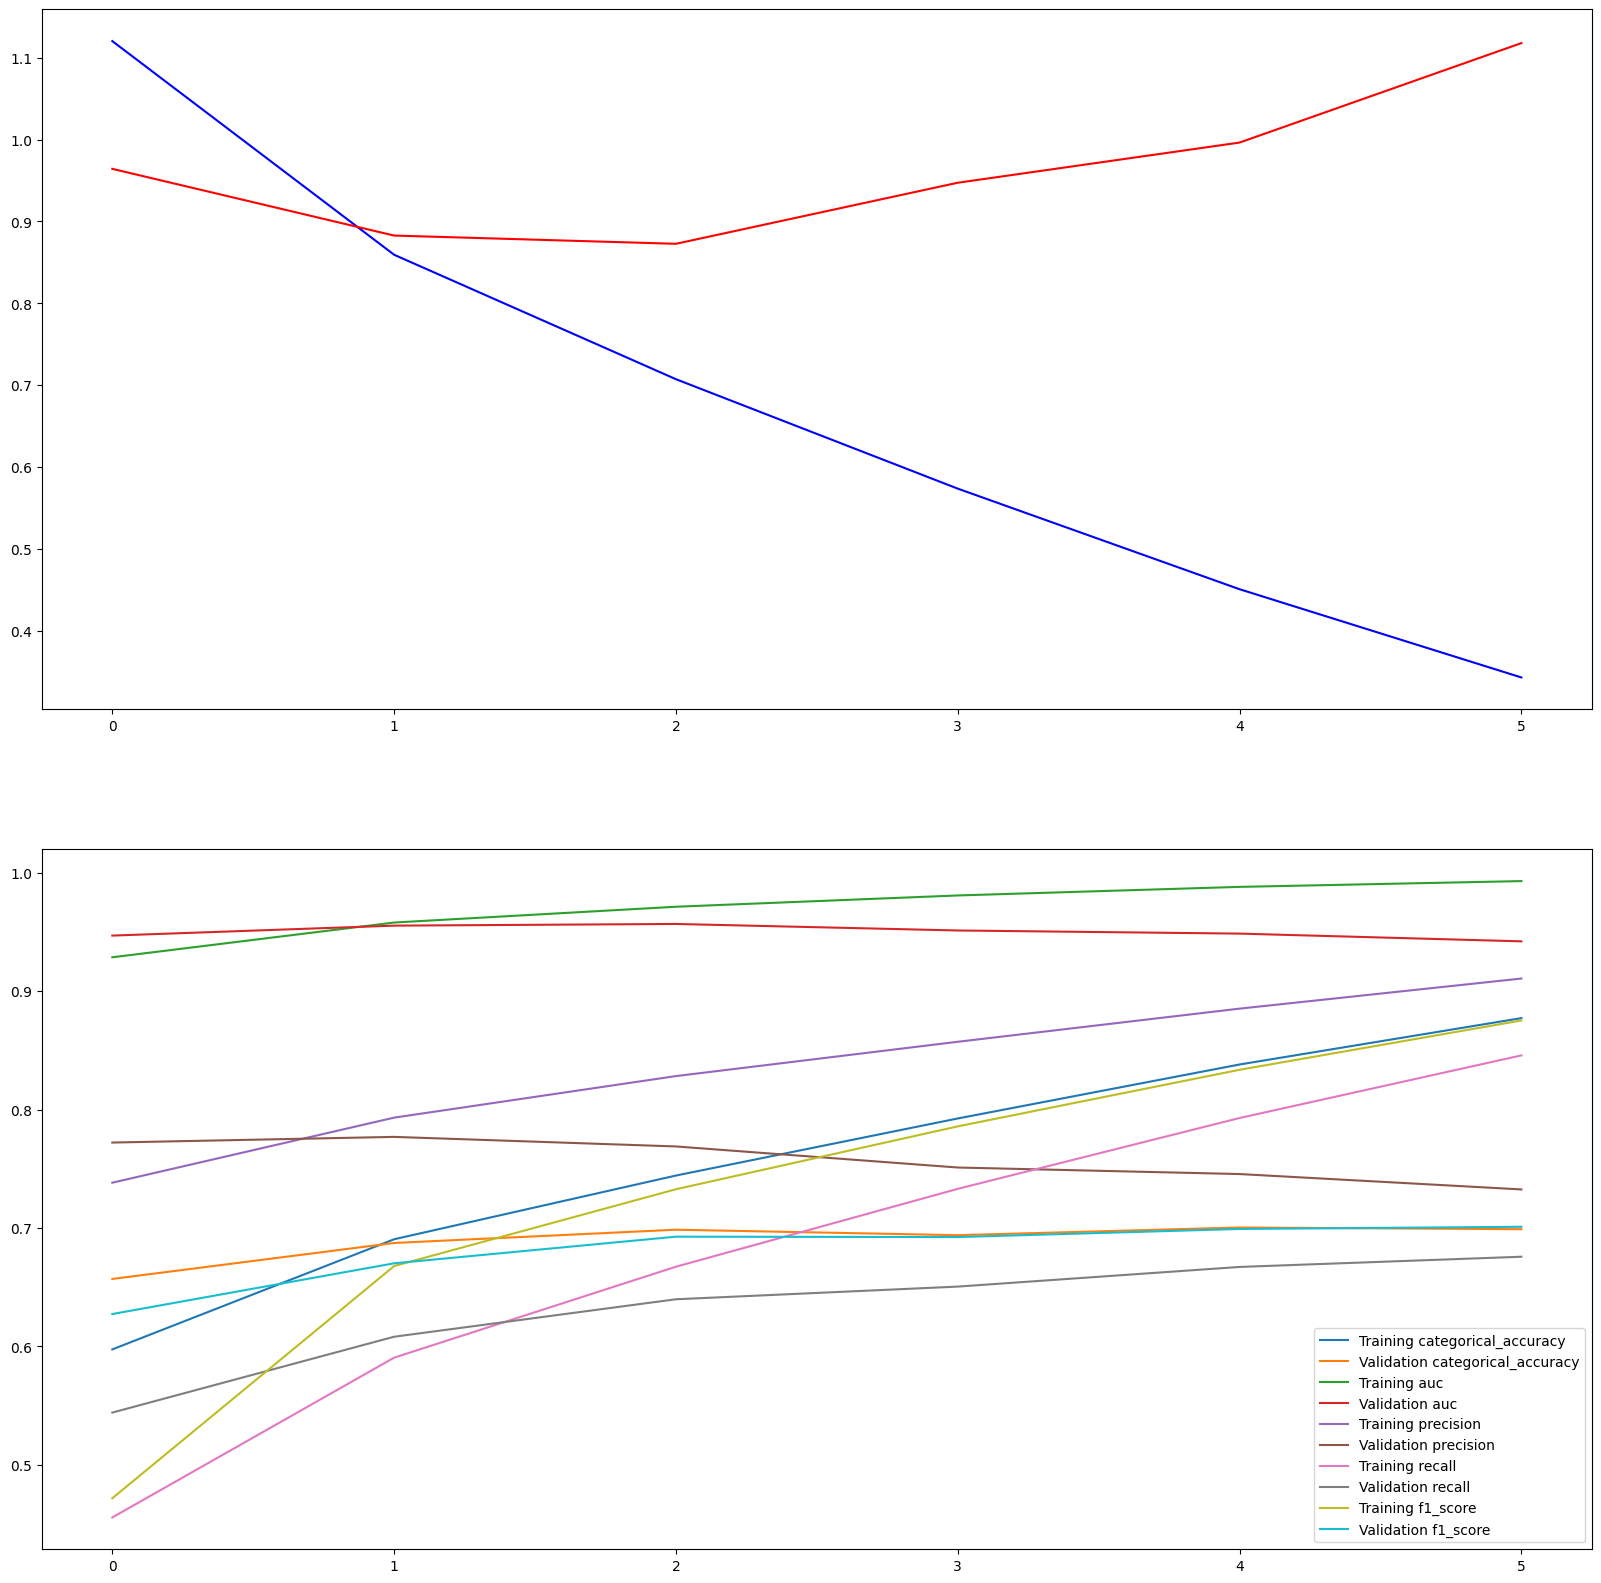

In [22]:
show_training_validation_loss_and_metrics(model,metrics2)

In [23]:
model.evaluate(test_ds)

5625/5625 [==============================] - 40s 7ms/step - loss: 1.1254 - categorical_accuracy: 0.6982 - auc: 0.9417 - precision: 0.7316 - recall: 0.6756 - f1_score: 0.7005


[1.1253514289855957,
 0.6982222199440002,
 0.9416985511779785,
 0.7315623760223389,
 0.6756222248077393,
 0.7005394697189331]

5625/5625 [==============================] - 29s 5ms/step


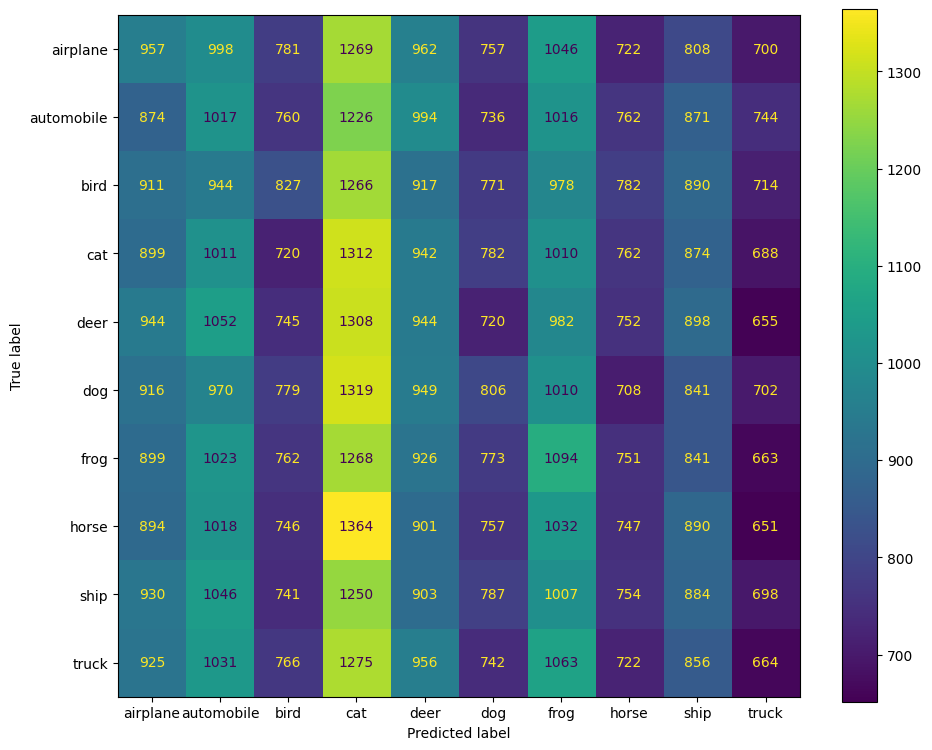

In [24]:
show_confusion_matrix(model,test_ds,num_classes,class_names)

5625/5625 [==============================] - 31s 6ms/step


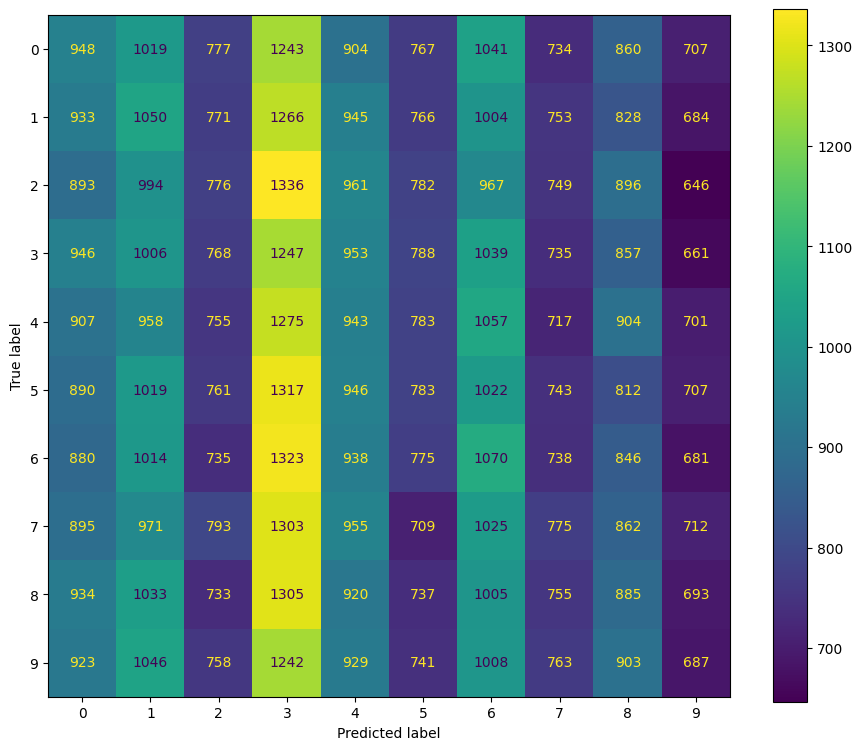

In [25]:
show_confusion_matrix_without_names(model,test_ds,num_classes)

# Ziarno 1234

In [10]:
SEED = 1234

tf.random.set_seed(SEED)
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False)

In [11]:
# Freeze base model
base_model.trainable = False

In [12]:
# Create inputs with correct shape
inputs = keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalMaxPooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs,outputs)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 5,130
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
model.compile(loss='categorical_crossentropy', metrics=metrics)

In [15]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_ds,
          validation_data=validation_ds,
          epochs=nb_epochs,
          callbacks=[callback]
        )

Epoch 1/20
5625/5625 [==============================] - 104s 16ms/step - loss: 1.6404 - categorical_accuracy: 0.4239 - auc: 0.8403 - precision: 0.6513 - recall: 0.1599 - f1_score: 0.2433 - val_loss: 1.5471 - val_categorical_accuracy: 0.4595 - val_auc: 0.8604 - val_precision: 0.6613 - val_recall: 0.2204 - val_f1_score: 0.3142
Epoch 2/20
5625/5625 [==============================] - 76s 14ms/step - loss: 1.5328 - categorical_accuracy: 0.4651 - auc: 0.8635 - precision: 0.6524 - recall: 0.2463 - f1_score: 0.3419 - val_loss: 1.5290 - val_categorical_accuracy: 0.4699 - val_auc: 0.8651 - val_precision: 0.6499 - val_recall: 0.2591 - val_f1_score: 0.3490
Epoch 3/20
5625/5625 [==============================] - 80s 14ms/step - loss: 1.5168 - categorical_accuracy: 0.4746 - auc: 0.8674 - precision: 0.6503 - recall: 0.2709 - f1_score: 0.3670 - val_loss: 1.5250 - val_categorical_accuracy: 0.4754 - val_auc: 0.8669 - val_precision: 0.6453 - val_recall: 0.2761 - val_f1_score: 0.3677
Epoch 4/20
5625/5625 

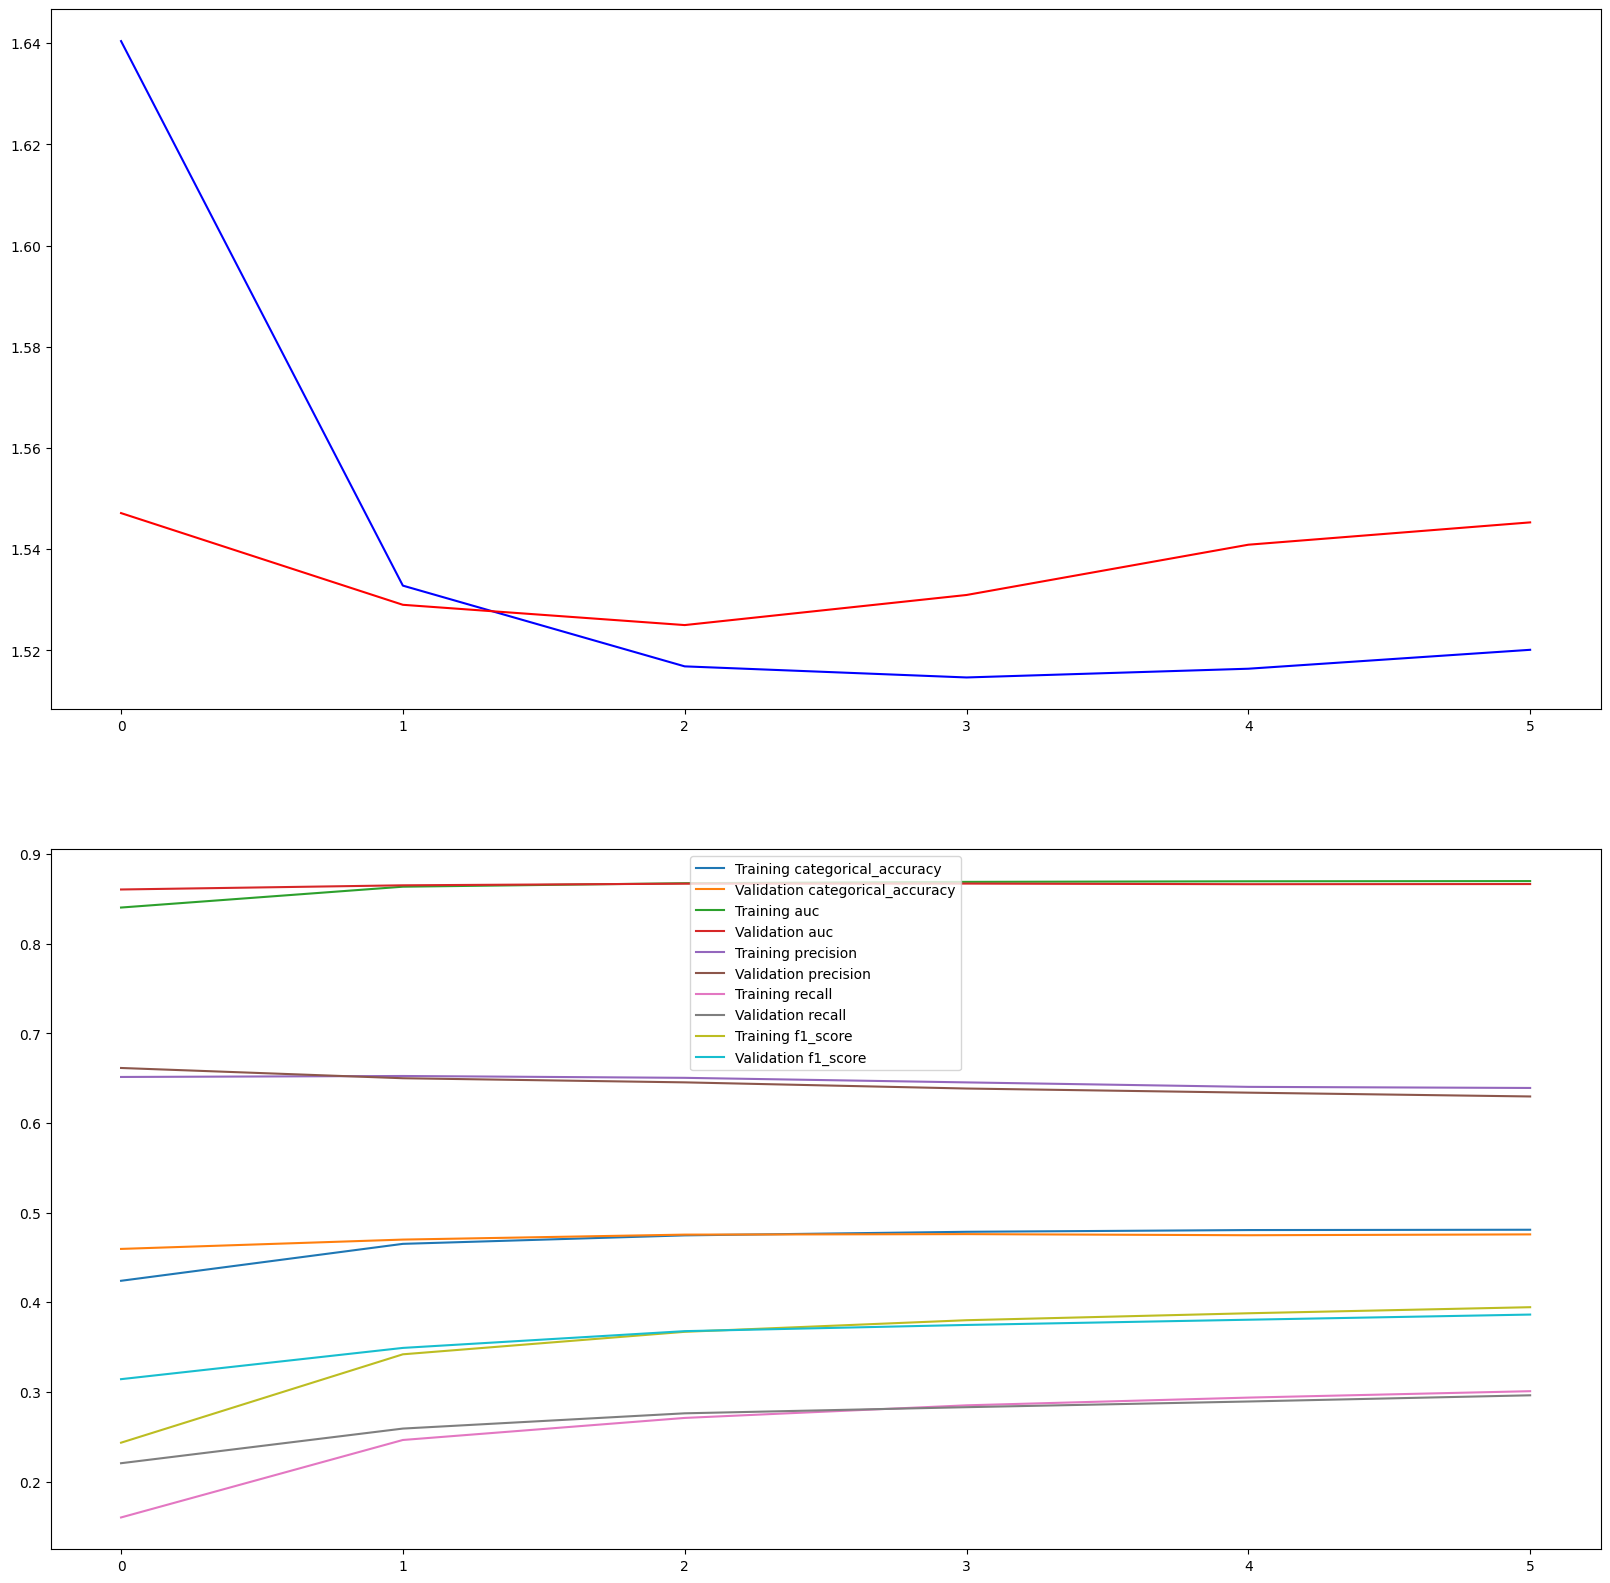

In [16]:
show_training_validation_loss_and_metrics(model,metrics2) 

In [17]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate = .00001),
              loss = 'categorical_crossentropy' , metrics = metrics)

In [18]:
#callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_ds,
          validation_data=validation_ds,
          epochs=nb_epochs,
          callbacks=[callback]
)

Epoch 1/20


5625/5625 [==============================] - 106s 18ms/step - loss: 1.1171 - categorical_accuracy: 0.6016 - auc: 0.9289 - precision: 0.7399 - recall: 0.4601 - f1_score: 0.4737 - val_loss: 0.9630 - val_categorical_accuracy: 0.6547 - val_auc: 0.9476 - val_precision: 0.7809 - val_recall: 0.5274 - val_f1_score: 0.6189
Epoch 2/20
5625/5625 [==============================] - 105s 19ms/step - loss: 0.8561 - categorical_accuracy: 0.6915 - auc: 0.9582 - precision: 0.7943 - recall: 0.5937 - f1_score: 0.6706 - val_loss: 0.8737 - val_categorical_accuracy: 0.6883 - val_auc: 0.9561 - val_precision: 0.7849 - val_recall: 0.6000 - val_f1_score: 0.6726
Epoch 3/20
5625/5625 [==============================] - 105s 19ms/step - loss: 0.7031 - categorical_accuracy: 0.7451 - auc: 0.9715 - precision: 0.8283 - recall: 0.6690 - f1_score: 0.7339 - val_loss: 0.8834 - val_categorical_accuracy: 0.6905 - val_auc: 0.9553 - val_precision: 0.7730 - val_recall: 0.6194 - val_f1_score: 0.6853
Epoch 4/20
5625/5625 [========

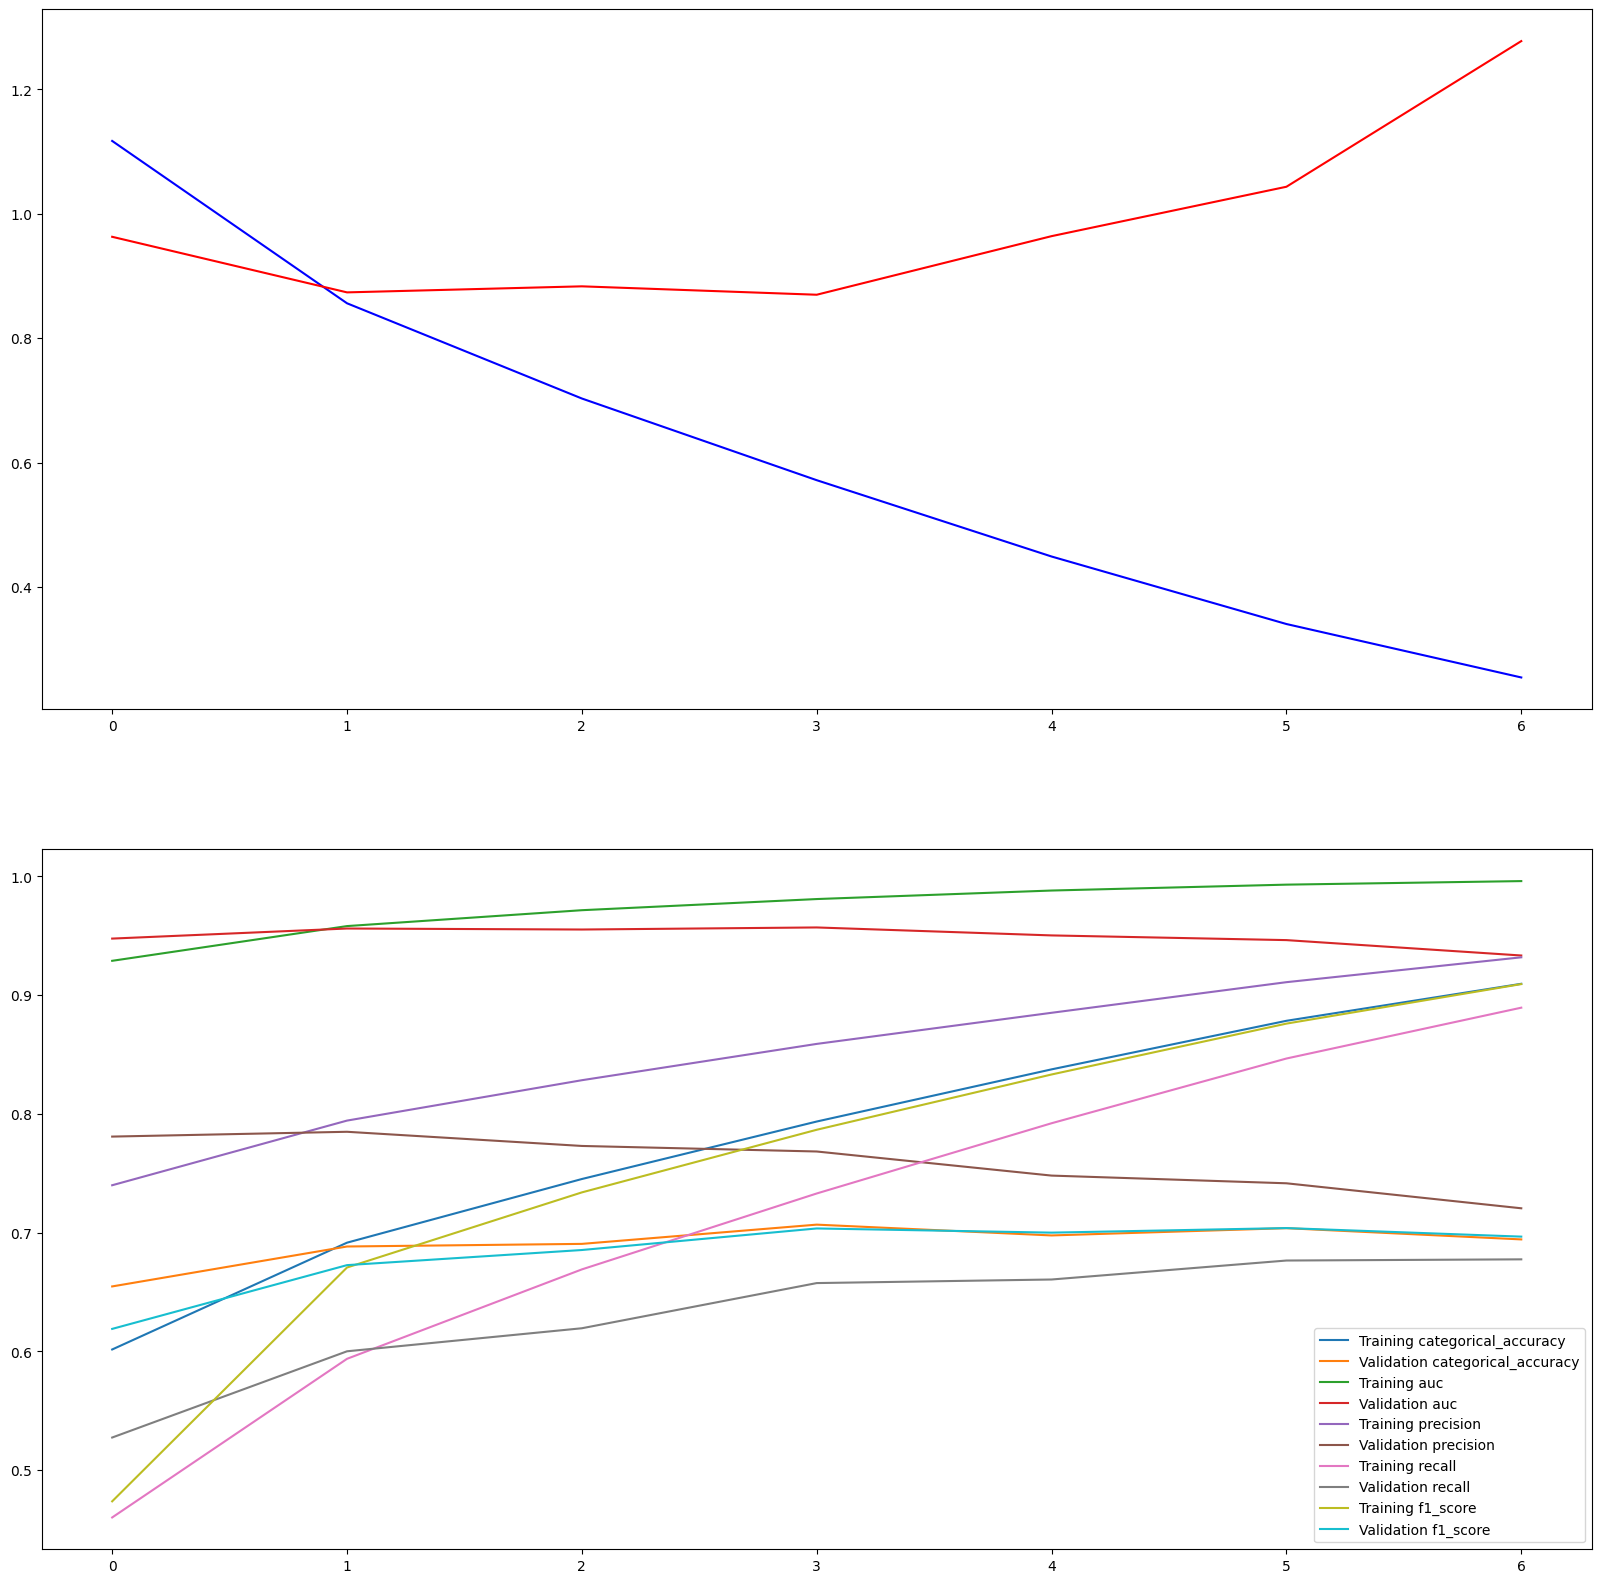

In [19]:
show_training_validation_loss_and_metrics(model,metrics2)

In [20]:
model.evaluate(test_ds)

5625/5625 [==============================] - 40s 7ms/step - loss: 1.2809 - categorical_accuracy: 0.6926 - auc: 0.9333 - precision: 0.7189 - recall: 0.6761 - f1_score: 0.6954


[1.2809135913848877,
 0.6926110982894897,
 0.9332783818244934,
 0.7188913822174072,
 0.6761333346366882,
 0.6953994035720825]

5625/5625 [==============================] - 30s 5ms/step


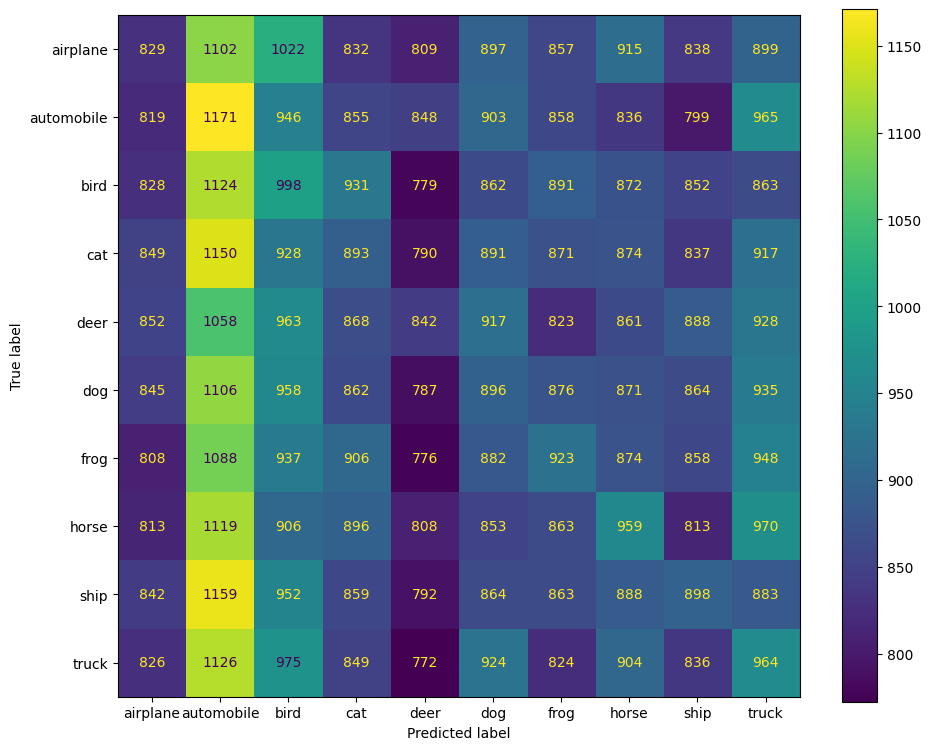

In [21]:
show_confusion_matrix(model,test_ds,num_classes,class_names)

5625/5625 [==============================] - 30s 5ms/step


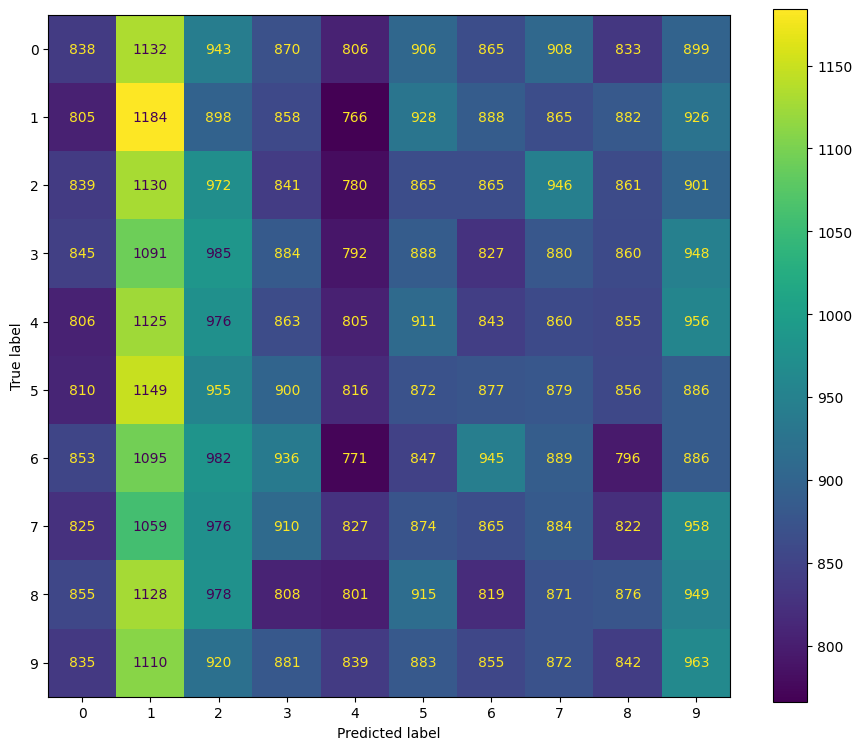

In [22]:
show_confusion_matrix_without_names(model,test_ds,num_classes)

# Ziarno 2137

In [23]:
SEED = 2137

tf.random.set_seed(SEED)
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False)

In [24]:
# Freeze base model
base_model.trainable = False

In [25]:
# Create inputs with correct shape
inputs = keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalMaxPooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs,outputs)

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 5,130
Non-trainable params: 14,714,688
_________________________________________________________________


In [27]:
model.compile(loss='categorical_crossentropy', metrics=metrics)

In [28]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_ds,
          validation_data=validation_ds,
          epochs=nb_epochs,
          callbacks=[callback]
        )

Epoch 1/20


5625/5625 [==============================] - 80s 14ms/step - loss: 1.6391 - categorical_accuracy: 0.4243 - auc: 0.8406 - precision: 0.6520 - recall: 0.1595 - f1_score: 0.5203 - val_loss: 1.5502 - val_categorical_accuracy: 0.4593 - val_auc: 0.8598 - val_precision: 0.6590 - val_recall: 0.2232 - val_f1_score: 0.3135
Epoch 2/20
5625/5625 [==============================] - 79s 14ms/step - loss: 1.5328 - categorical_accuracy: 0.4661 - auc: 0.8635 - precision: 0.6526 - recall: 0.2468 - f1_score: 0.3423 - val_loss: 1.5261 - val_categorical_accuracy: 0.4707 - val_auc: 0.8656 - val_precision: 0.6523 - val_recall: 0.2585 - val_f1_score: 0.3512
Epoch 3/20
5625/5625 [==============================] - 82s 14ms/step - loss: 1.5172 - categorical_accuracy: 0.4752 - auc: 0.8675 - precision: 0.6490 - recall: 0.2703 - f1_score: 0.3660 - val_loss: 1.5278 - val_categorical_accuracy: 0.4743 - val_auc: 0.8665 - val_precision: 0.6458 - val_recall: 0.2715 - val_f1_score: 0.3648
Epoch 4/20
5625/5625 [===========

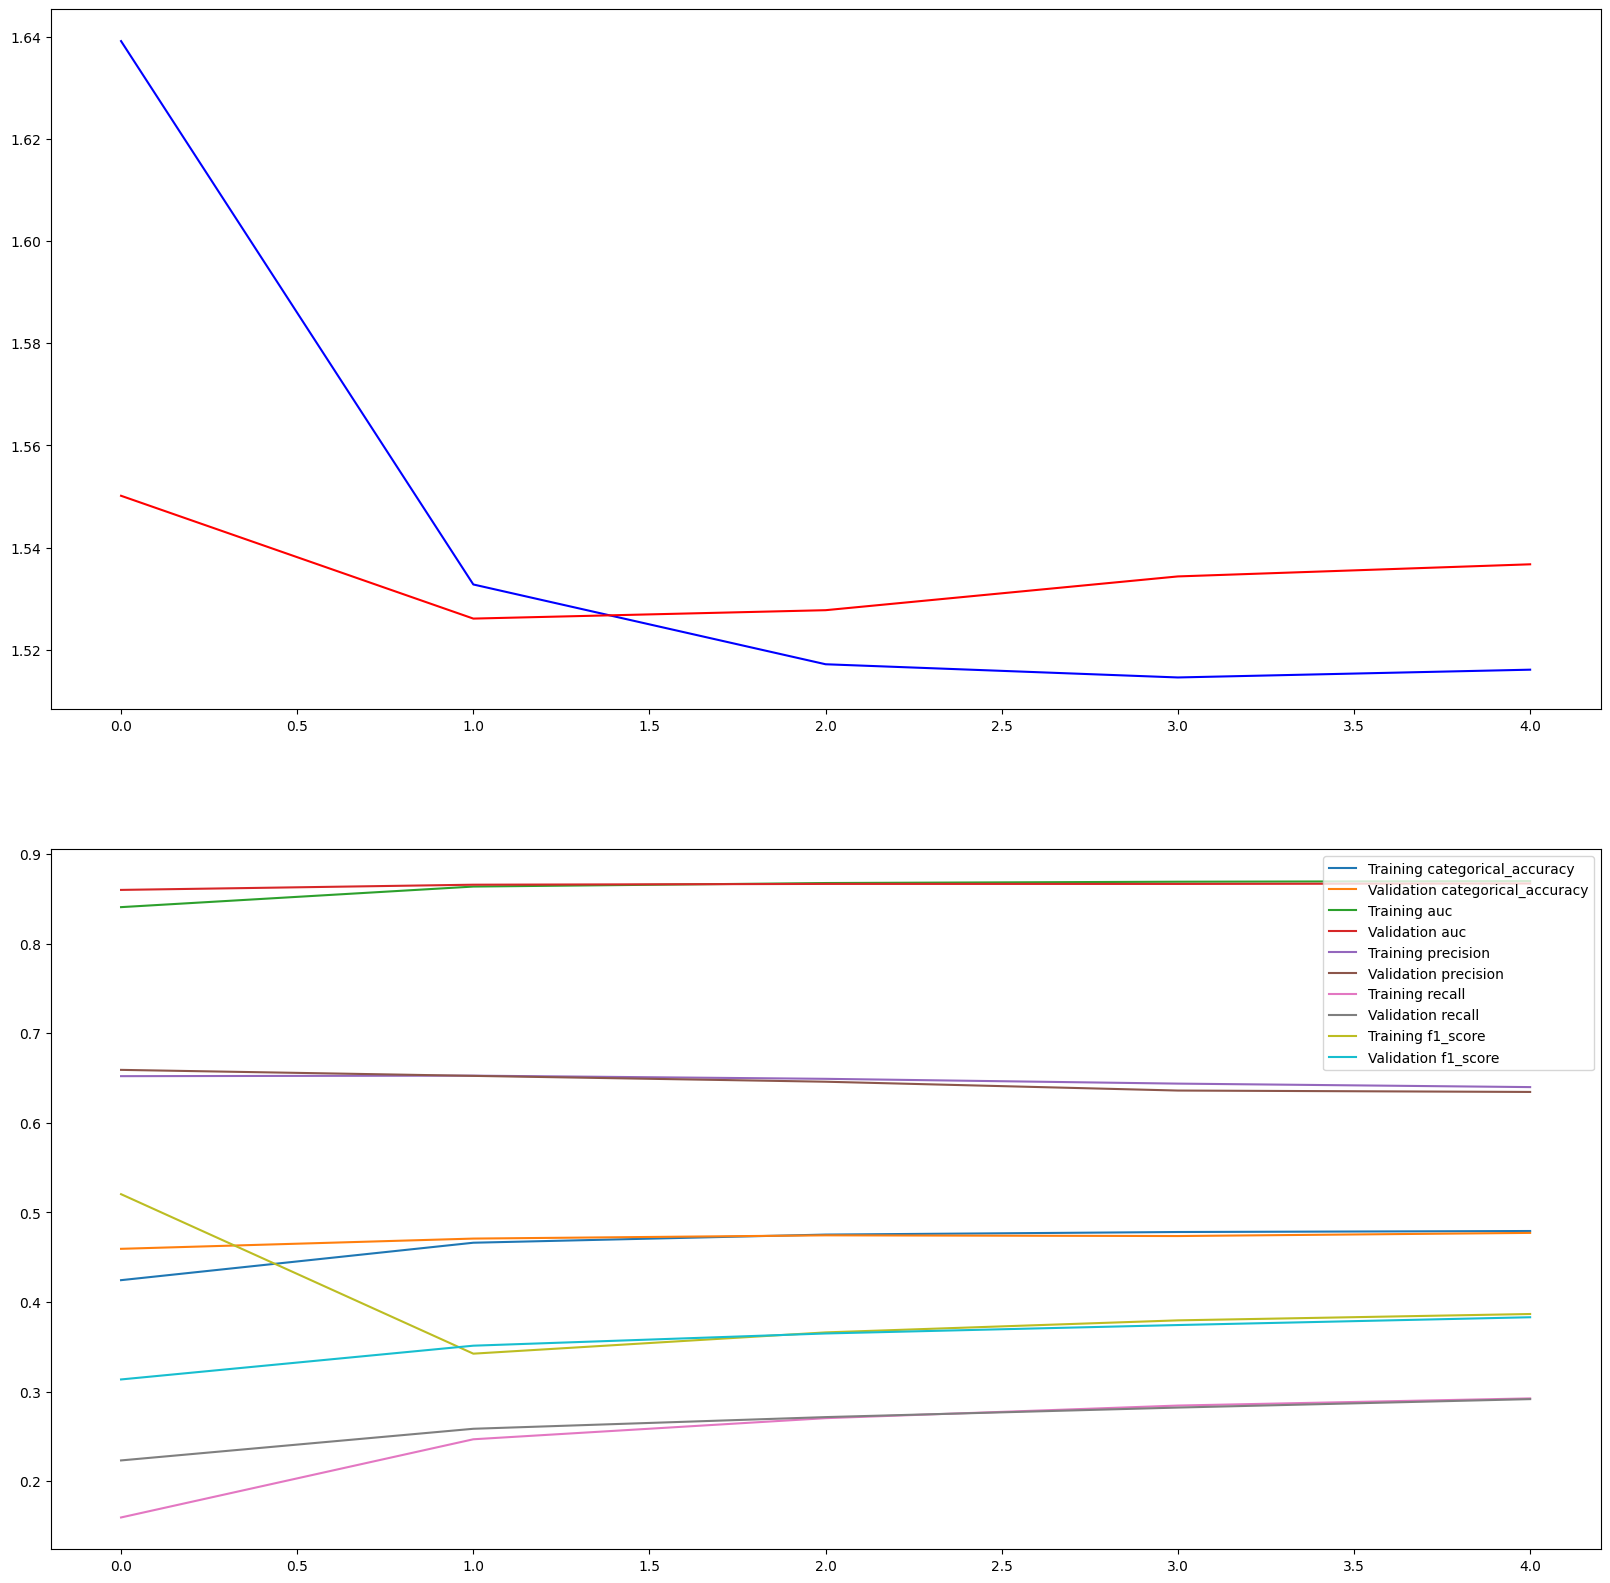

In [29]:
show_training_validation_loss_and_metrics(model,metrics2) 

In [30]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate = .00001),
              loss = 'categorical_crossentropy' , metrics = metrics)

In [31]:
#callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_ds,
          validation_data=validation_ds,
          epochs=nb_epochs,
          callbacks=[callback]
)

Epoch 1/20


5625/5625 [==============================] - 105s 19ms/step - loss: 1.1155 - categorical_accuracy: 0.6001 - auc: 0.9292 - precision: 0.7418 - recall: 0.4585 - f1_score: 0.4722 - val_loss: 0.9461 - val_categorical_accuracy: 0.6634 - val_auc: 0.9497 - val_precision: 0.7957 - val_recall: 0.5301 - val_f1_score: 0.6207
Epoch 2/20
5625/5625 [==============================] - 104s 18ms/step - loss: 0.8540 - categorical_accuracy: 0.6932 - auc: 0.9584 - precision: 0.7957 - recall: 0.5959 - f1_score: 0.6724 - val_loss: 0.8820 - val_categorical_accuracy: 0.6860 - val_auc: 0.9553 - val_precision: 0.7857 - val_recall: 0.5931 - val_f1_score: 0.6714
Epoch 3/20
5625/5625 [==============================] - 107s 19ms/step - loss: 0.7013 - categorical_accuracy: 0.7473 - auc: 0.9716 - precision: 0.8304 - recall: 0.6699 - f1_score: 0.7352 - val_loss: 0.8659 - val_categorical_accuracy: 0.6981 - val_auc: 0.9568 - val_precision: 0.7767 - val_recall: 0.6324 - val_f1_score: 0.6934
Epoch 4/20
5625/5625 [========

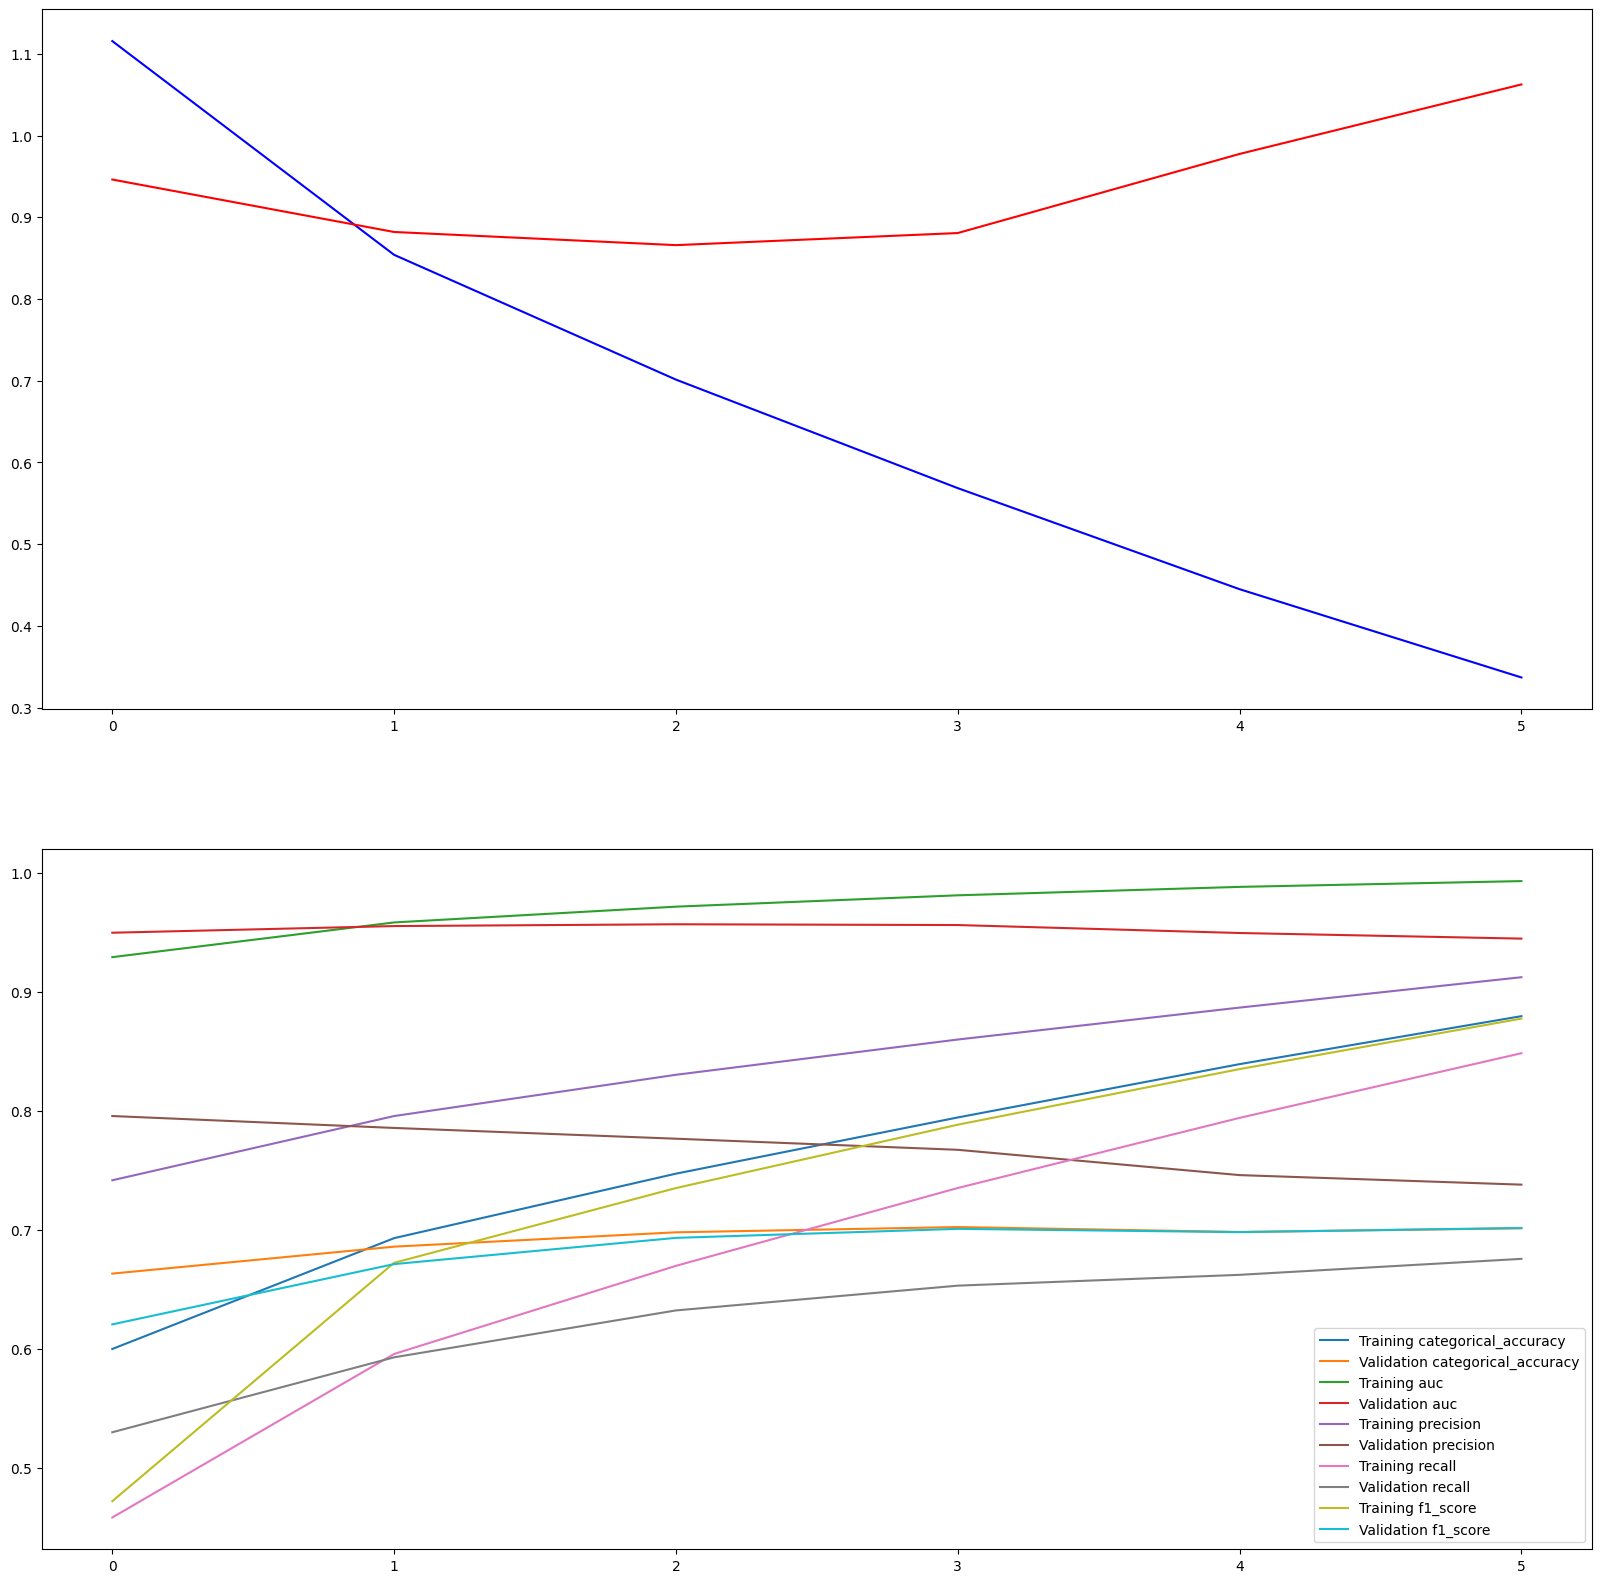

In [32]:
show_training_validation_loss_and_metrics(model,metrics2)

In [33]:
model.evaluate(test_ds)

5625/5625 [==============================] - 41s 7ms/step - loss: 1.0651 - categorical_accuracy: 0.6999 - auc: 0.9445 - precision: 0.7374 - recall: 0.6749 - f1_score: 0.7013


[1.0651332139968872,
 0.6998888850212097,
 0.9445485472679138,
 0.7374171614646912,
 0.6749333143234253,
 0.7012830972671509]

5625/5625 [==============================] - 30s 5ms/step


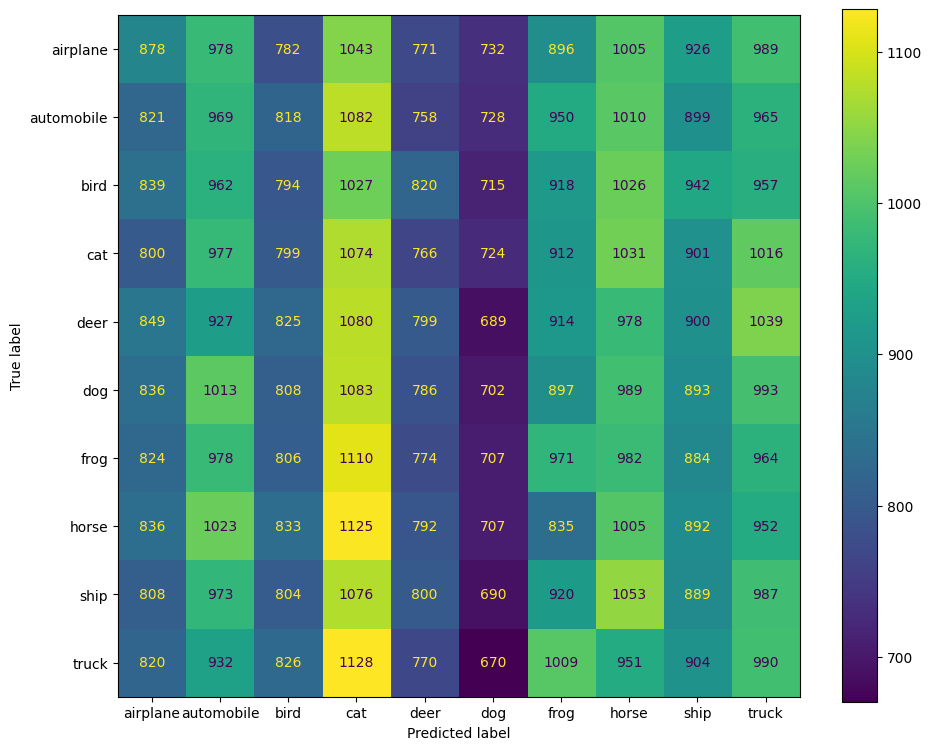

In [34]:
show_confusion_matrix(model,test_ds,num_classes,class_names)

5625/5625 [==============================] - 30s 5ms/step


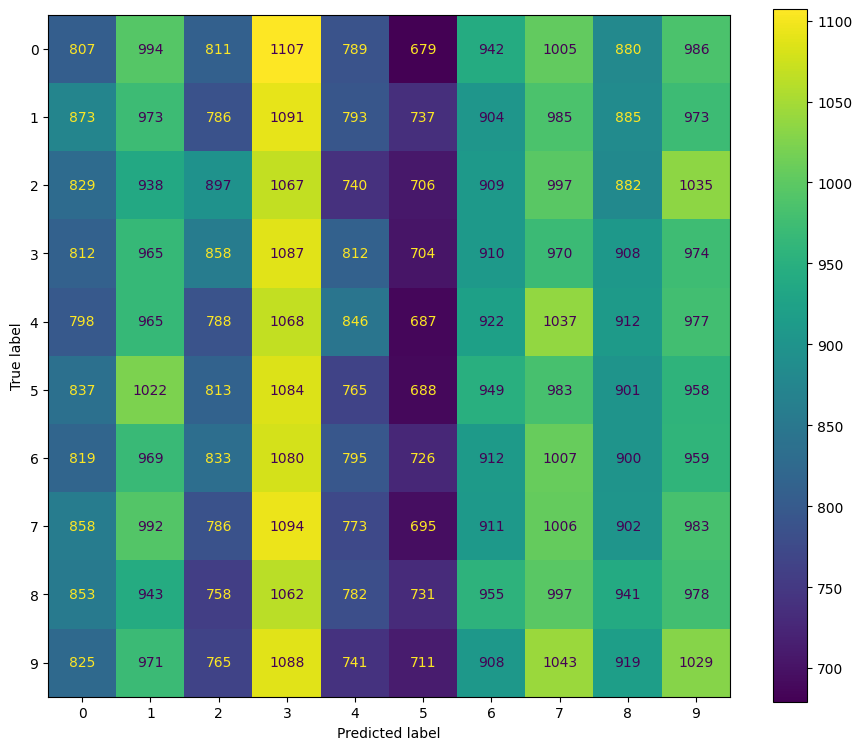

In [35]:
show_confusion_matrix_without_names(model,test_ds,num_classes)

# Ziarno 7654

In [36]:
SEED = 7654

tf.random.set_seed(SEED)
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False)

In [37]:
# Freeze base model
base_model.trainable = False

In [38]:
# Create inputs with correct shape
inputs = keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalMaxPooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs,outputs)

In [39]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 5,130
Non-trainable params: 14,714,688
_________________________________________________________________


In [40]:
model.compile(loss='categorical_crossentropy', metrics=metrics)

In [41]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_ds,
          validation_data=validation_ds,
          epochs=nb_epochs,
          callbacks=[callback]
        )

Epoch 1/20


5625/5625 [==============================] - 81s 14ms/step - loss: 1.6365 - categorical_accuracy: 0.4259 - auc: 0.8412 - precision: 0.6525 - recall: 0.1611 - f1_score: 0.5231 - val_loss: 1.5467 - val_categorical_accuracy: 0.4604 - val_auc: 0.8605 - val_precision: 0.6620 - val_recall: 0.2207 - val_f1_score: 0.3142
Epoch 2/20
5625/5625 [==============================] - 81s 14ms/step - loss: 1.5317 - categorical_accuracy: 0.4641 - auc: 0.8637 - precision: 0.6538 - recall: 0.2473 - f1_score: 0.3430 - val_loss: 1.5286 - val_categorical_accuracy: 0.4701 - val_auc: 0.8652 - val_precision: 0.6494 - val_recall: 0.2595 - val_f1_score: 0.3488
Epoch 3/20
5625/5625 [==============================] - 77s 14ms/step - loss: 1.5162 - categorical_accuracy: 0.4740 - auc: 0.8676 - precision: 0.6485 - recall: 0.2703 - f1_score: 0.3658 - val_loss: 1.5252 - val_categorical_accuracy: 0.4748 - val_auc: 0.8669 - val_precision: 0.6475 - val_recall: 0.2728 - val_f1_score: 0.3671
Epoch 4/20
5625/5625 [===========

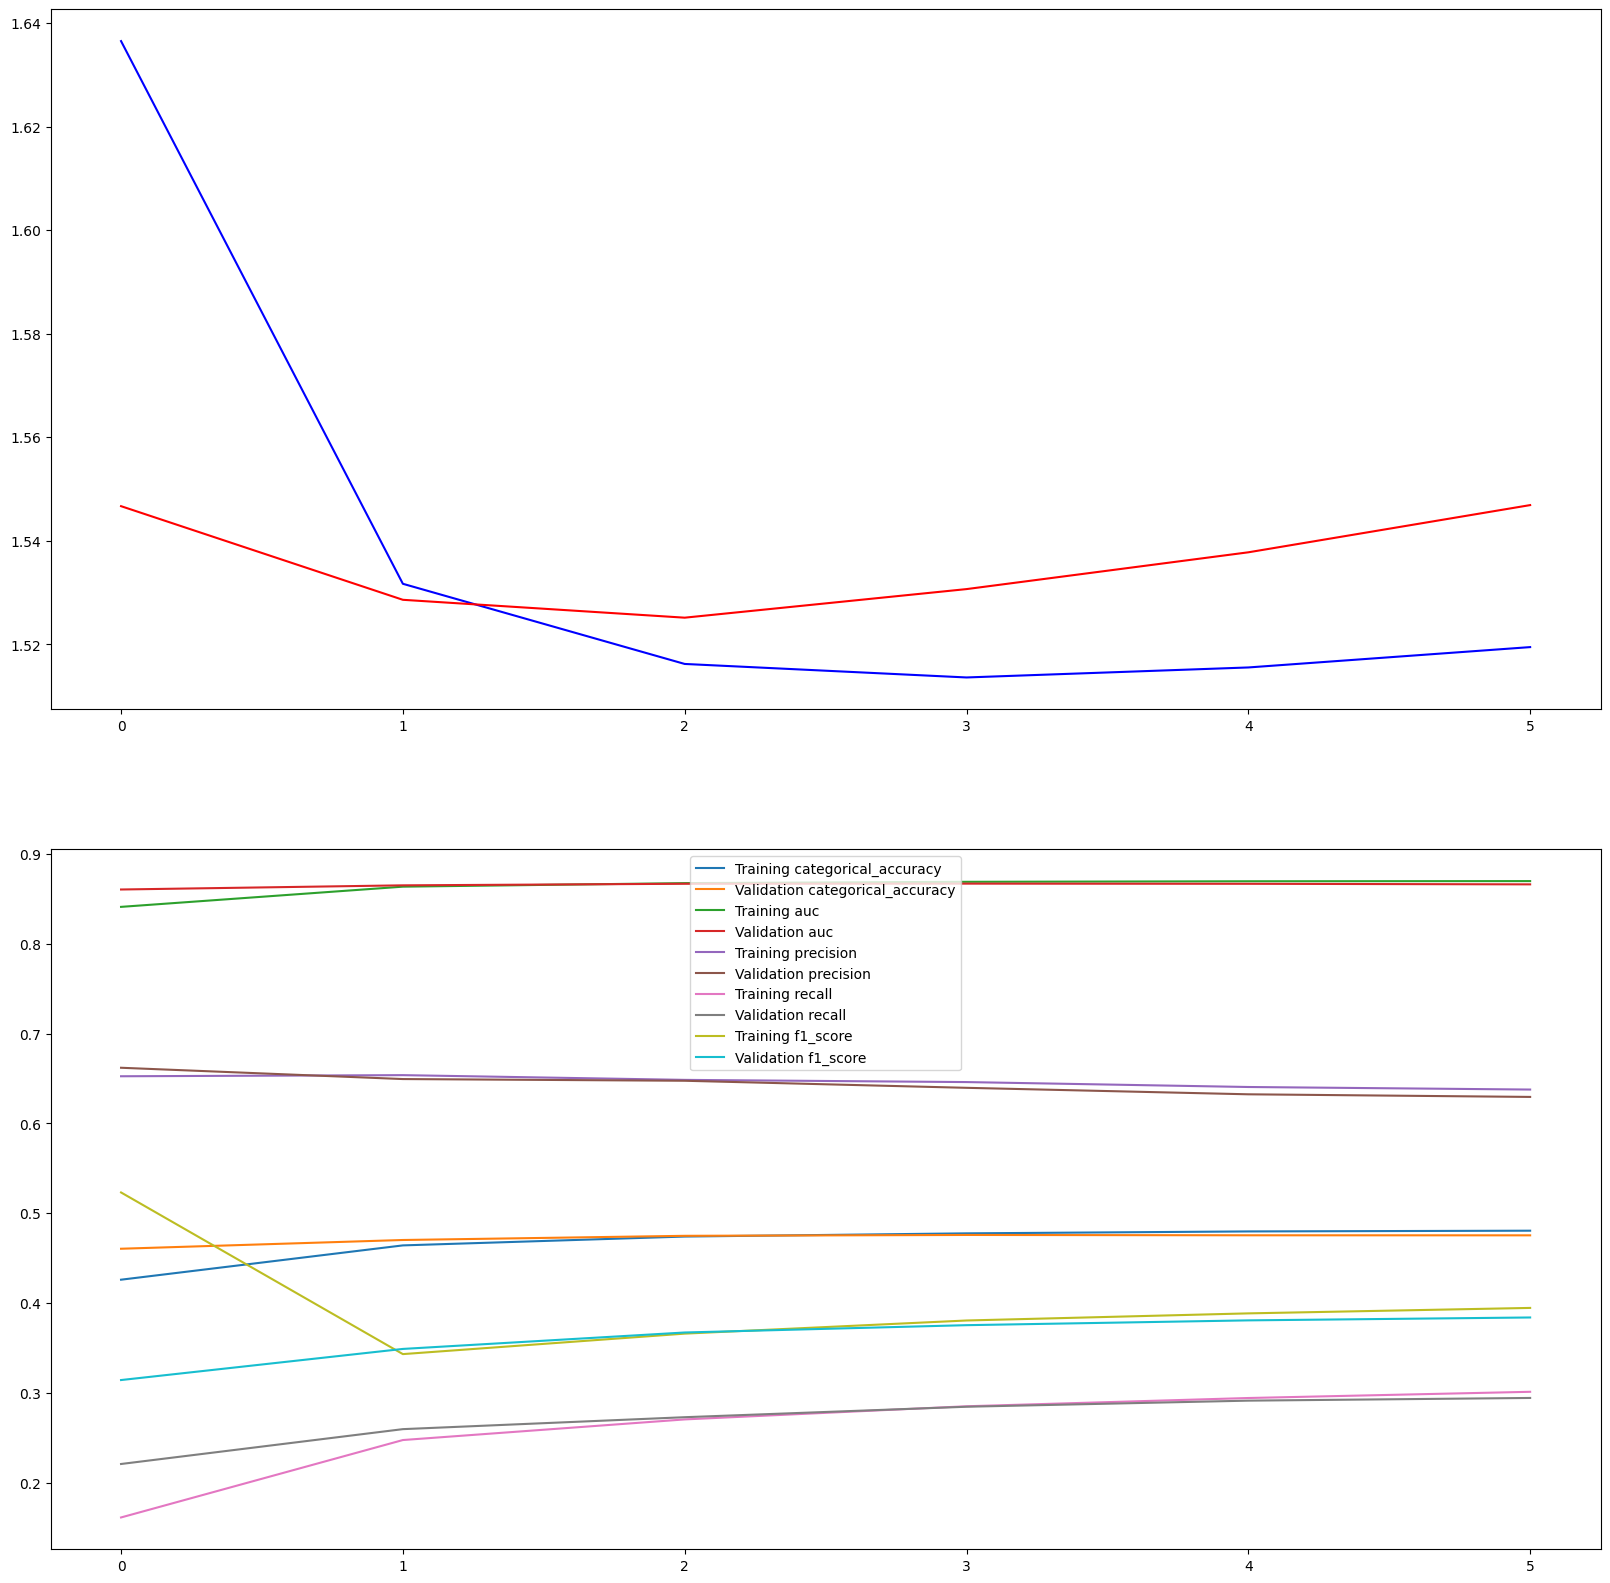

In [42]:
show_training_validation_loss_and_metrics(model,metrics2) 

In [43]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate = .00001),
              loss = 'categorical_crossentropy' , metrics = metrics)

In [44]:
#callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_ds,
          validation_data=validation_ds,
          epochs=nb_epochs,
          callbacks=[callback]
)

Epoch 1/20


5625/5625 [==============================] - 109s 19ms/step - loss: 1.1221 - categorical_accuracy: 0.5990 - auc: 0.9283 - precision: 0.7407 - recall: 0.4564 - f1_score: 0.4714 - val_loss: 0.9758 - val_categorical_accuracy: 0.6516 - val_auc: 0.9463 - val_precision: 0.7847 - val_recall: 0.5177 - val_f1_score: 0.6135
Epoch 2/20
5625/5625 [==============================] - 109s 19ms/step - loss: 0.8560 - categorical_accuracy: 0.6928 - auc: 0.9582 - precision: 0.7946 - recall: 0.5947 - f1_score: 0.6714 - val_loss: 0.8912 - val_categorical_accuracy: 0.6833 - val_auc: 0.9544 - val_precision: 0.7823 - val_recall: 0.5941 - val_f1_score: 0.6657
Epoch 3/20
5625/5625 [==============================] - 110s 20ms/step - loss: 0.7020 - categorical_accuracy: 0.7471 - auc: 0.9716 - precision: 0.8285 - recall: 0.6696 - f1_score: 0.7342 - val_loss: 0.8702 - val_categorical_accuracy: 0.6938 - val_auc: 0.9563 - val_precision: 0.7784 - val_recall: 0.6245 - val_f1_score: 0.6884
Epoch 4/20
5625/5625 [========

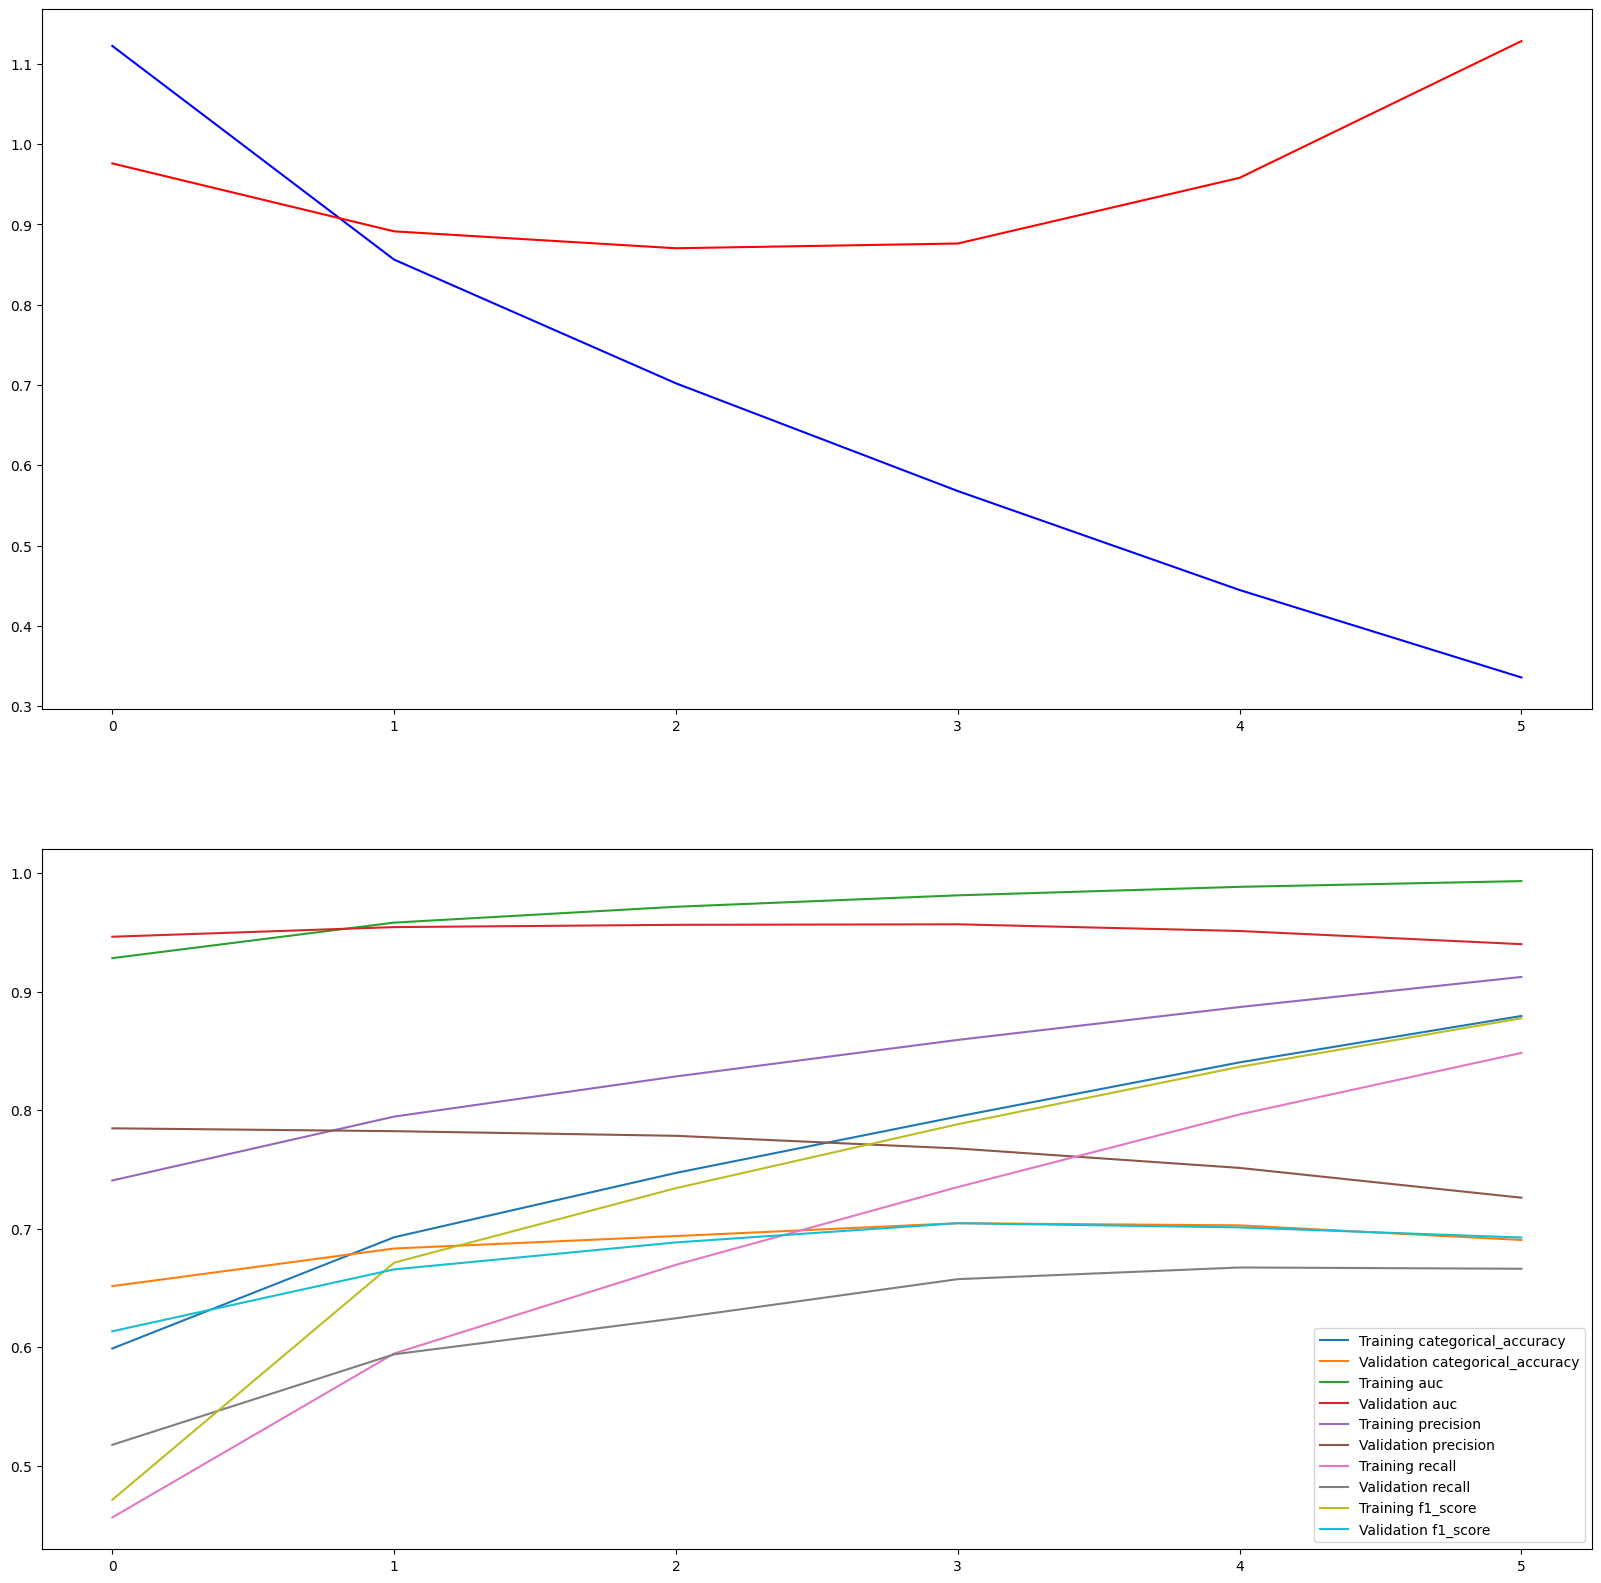

In [45]:
show_training_validation_loss_and_metrics(model,metrics2)

In [46]:
model.evaluate(test_ds)

5625/5625 [==============================] - 40s 7ms/step - loss: 1.1275 - categorical_accuracy: 0.6911 - auc: 0.9397 - precision: 0.7270 - recall: 0.6667 - f1_score: 0.6933


[1.127492904663086,
 0.6910889148712158,
 0.9397491812705994,
 0.7270414233207703,
 0.666688859462738,
 0.6933430433273315]

5625/5625 [==============================] - 29s 5ms/step


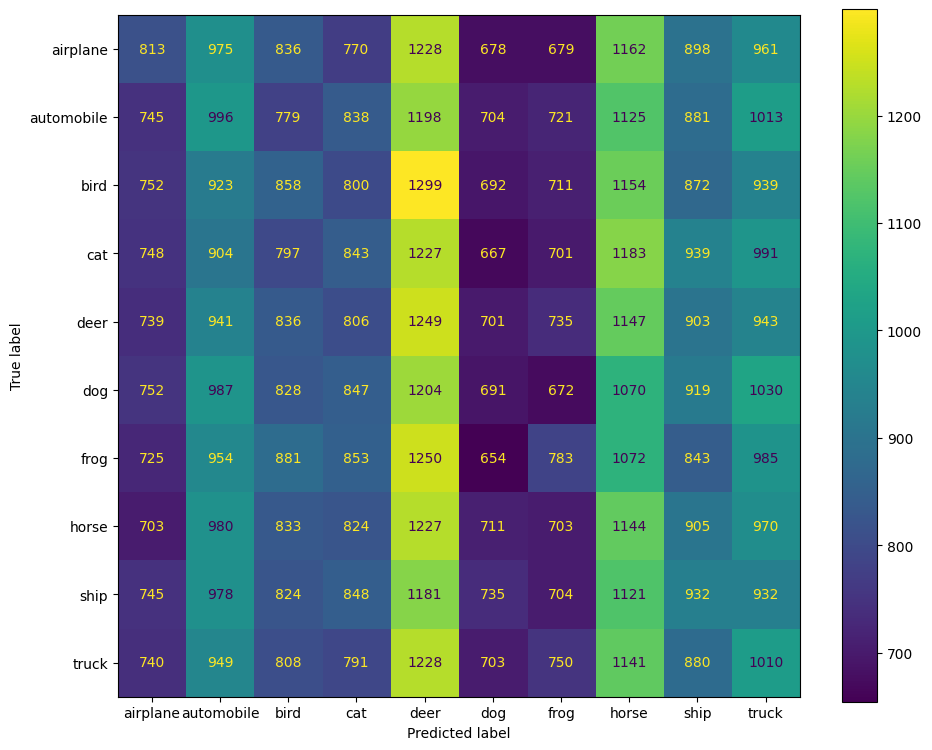

In [47]:
show_confusion_matrix(model,test_ds,num_classes,class_names)

5625/5625 [==============================] - 31s 5ms/step


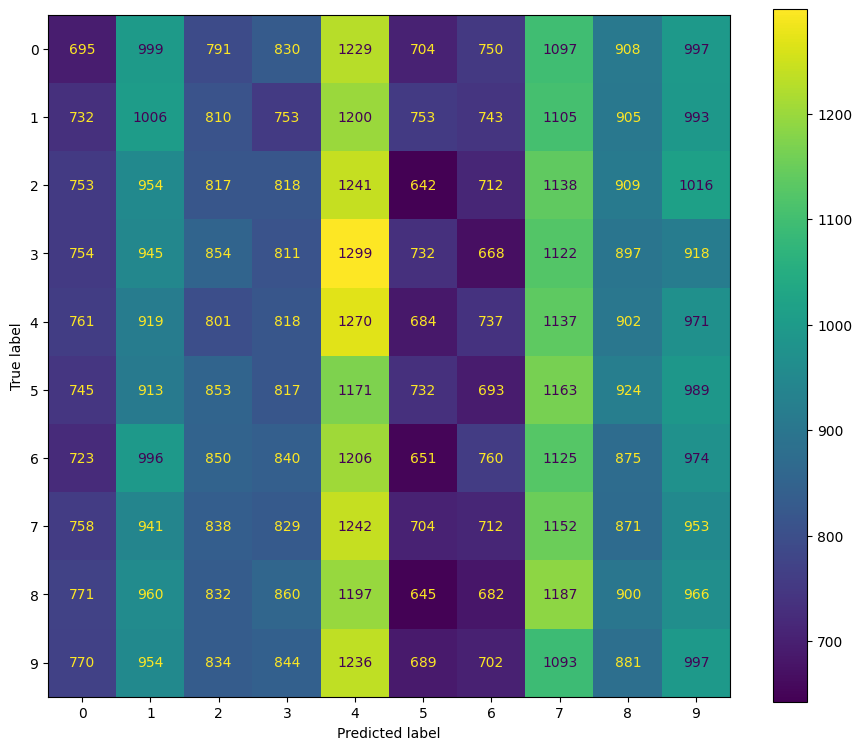

In [48]:
show_confusion_matrix_without_names(model,test_ds,num_classes)

# Ziarno 313

In [49]:
SEED = 313

tf.random.set_seed(SEED)
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False)

In [50]:
# Freeze base model
base_model.trainable = False

In [51]:
# Create inputs with correct shape
inputs = keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalMaxPooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs,outputs)

In [52]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_max_pooling2d_3 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 5,130
Non-trainable params: 14,714,688
_________________________________________________________________


In [53]:
model.compile(loss='categorical_crossentropy', metrics=metrics)

In [54]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_ds,
          validation_data=validation_ds,
          epochs=nb_epochs,
          callbacks=[callback]
        )

Epoch 1/20


5625/5625 [==============================] - 84s 15ms/step - loss: 1.6416 - categorical_accuracy: 0.4242 - auc: 0.8399 - precision: 0.6505 - recall: 0.1602 - f1_score: 0.5182 - val_loss: 1.5470 - val_categorical_accuracy: 0.4593 - val_auc: 0.8604 - val_precision: 0.6618 - val_recall: 0.2199 - val_f1_score: 0.3130
Epoch 2/20
5625/5625 [==============================] - 81s 14ms/step - loss: 1.5332 - categorical_accuracy: 0.4644 - auc: 0.8634 - precision: 0.6508 - recall: 0.2455 - f1_score: 0.3406 - val_loss: 1.5275 - val_categorical_accuracy: 0.4717 - val_auc: 0.8653 - val_precision: 0.6536 - val_recall: 0.2568 - val_f1_score: 0.3503
Epoch 3/20
5625/5625 [==============================] - 81s 14ms/step - loss: 1.5182 - categorical_accuracy: 0.4741 - auc: 0.8672 - precision: 0.6493 - recall: 0.2702 - f1_score: 0.3660 - val_loss: 1.5258 - val_categorical_accuracy: 0.4753 - val_auc: 0.8667 - val_precision: 0.6491 - val_recall: 0.2726 - val_f1_score: 0.3694
Epoch 4/20
5625/5625 [===========

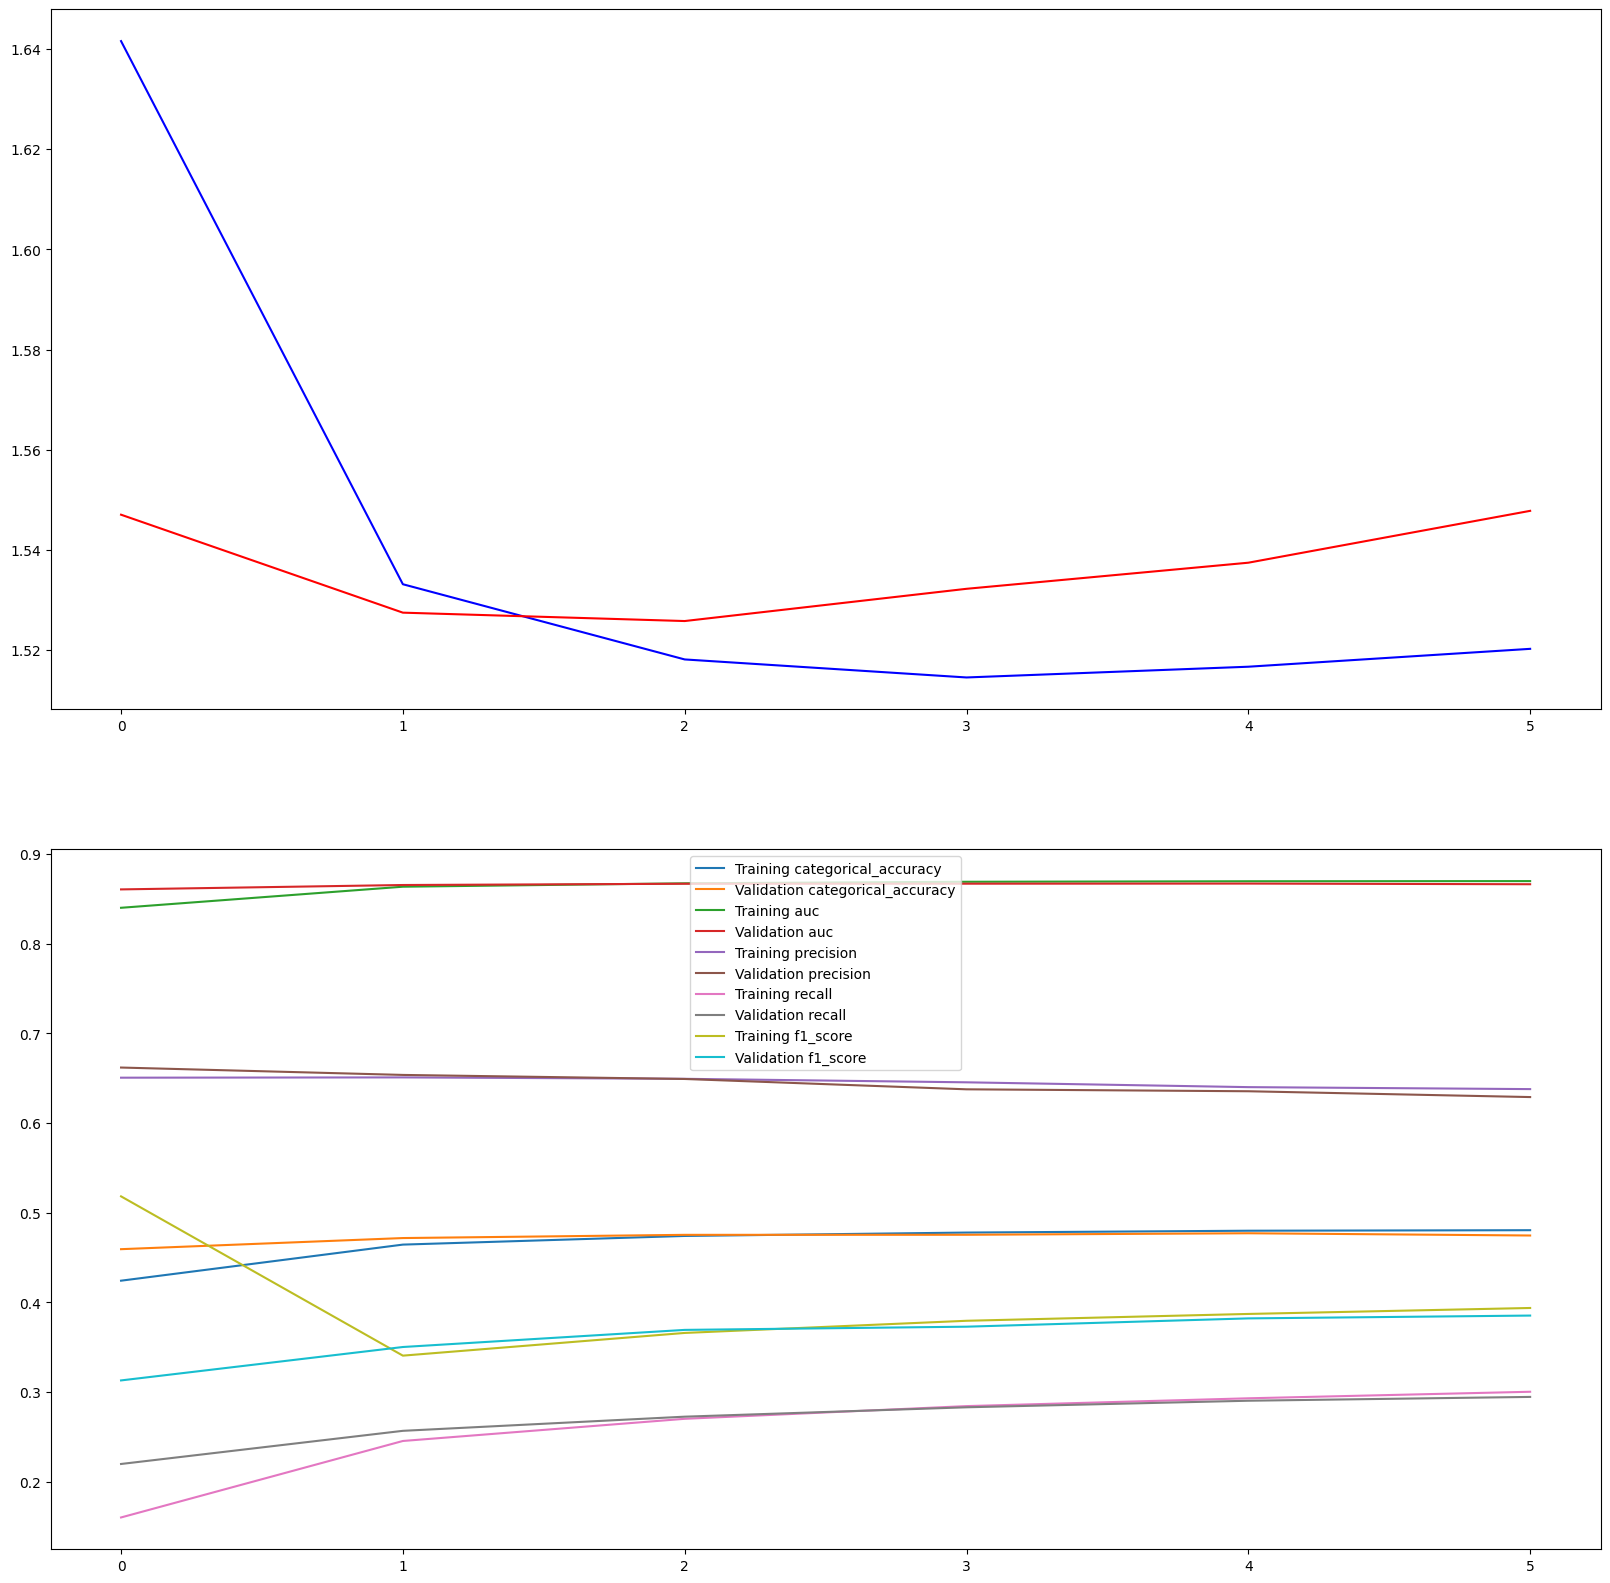

In [55]:
show_training_validation_loss_and_metrics(model,metrics2) 

In [56]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate = .00001),
              loss = 'categorical_crossentropy' , metrics = metrics)

In [57]:
#callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_ds,
          validation_data=validation_ds,
          epochs=nb_epochs,
          callbacks=[callback]
)

Epoch 1/20


5625/5625 [==============================] - 109s 19ms/step - loss: 1.1200 - categorical_accuracy: 0.5985 - auc: 0.9286 - precision: 0.7370 - recall: 0.4571 - f1_score: 0.4718 - val_loss: 0.9484 - val_categorical_accuracy: 0.6621 - val_auc: 0.9492 - val_precision: 0.7882 - val_recall: 0.5357 - val_f1_score: 0.6270
Epoch 2/20
5625/5625 [==============================] - 108s 19ms/step - loss: 0.8557 - categorical_accuracy: 0.6931 - auc: 0.9582 - precision: 0.7947 - recall: 0.5961 - f1_score: 0.6725 - val_loss: 0.8810 - val_categorical_accuracy: 0.6872 - val_auc: 0.9553 - val_precision: 0.7863 - val_recall: 0.5993 - val_f1_score: 0.6762
Epoch 3/20
5625/5625 [==============================] - 110s 20ms/step - loss: 0.7027 - categorical_accuracy: 0.7462 - auc: 0.9716 - precision: 0.8275 - recall: 0.6687 - f1_score: 0.7336 - val_loss: 0.8528 - val_categorical_accuracy: 0.7007 - val_auc: 0.9580 - val_precision: 0.7827 - val_recall: 0.6310 - val_f1_score: 0.6917
Epoch 4/20
5625/5625 [========

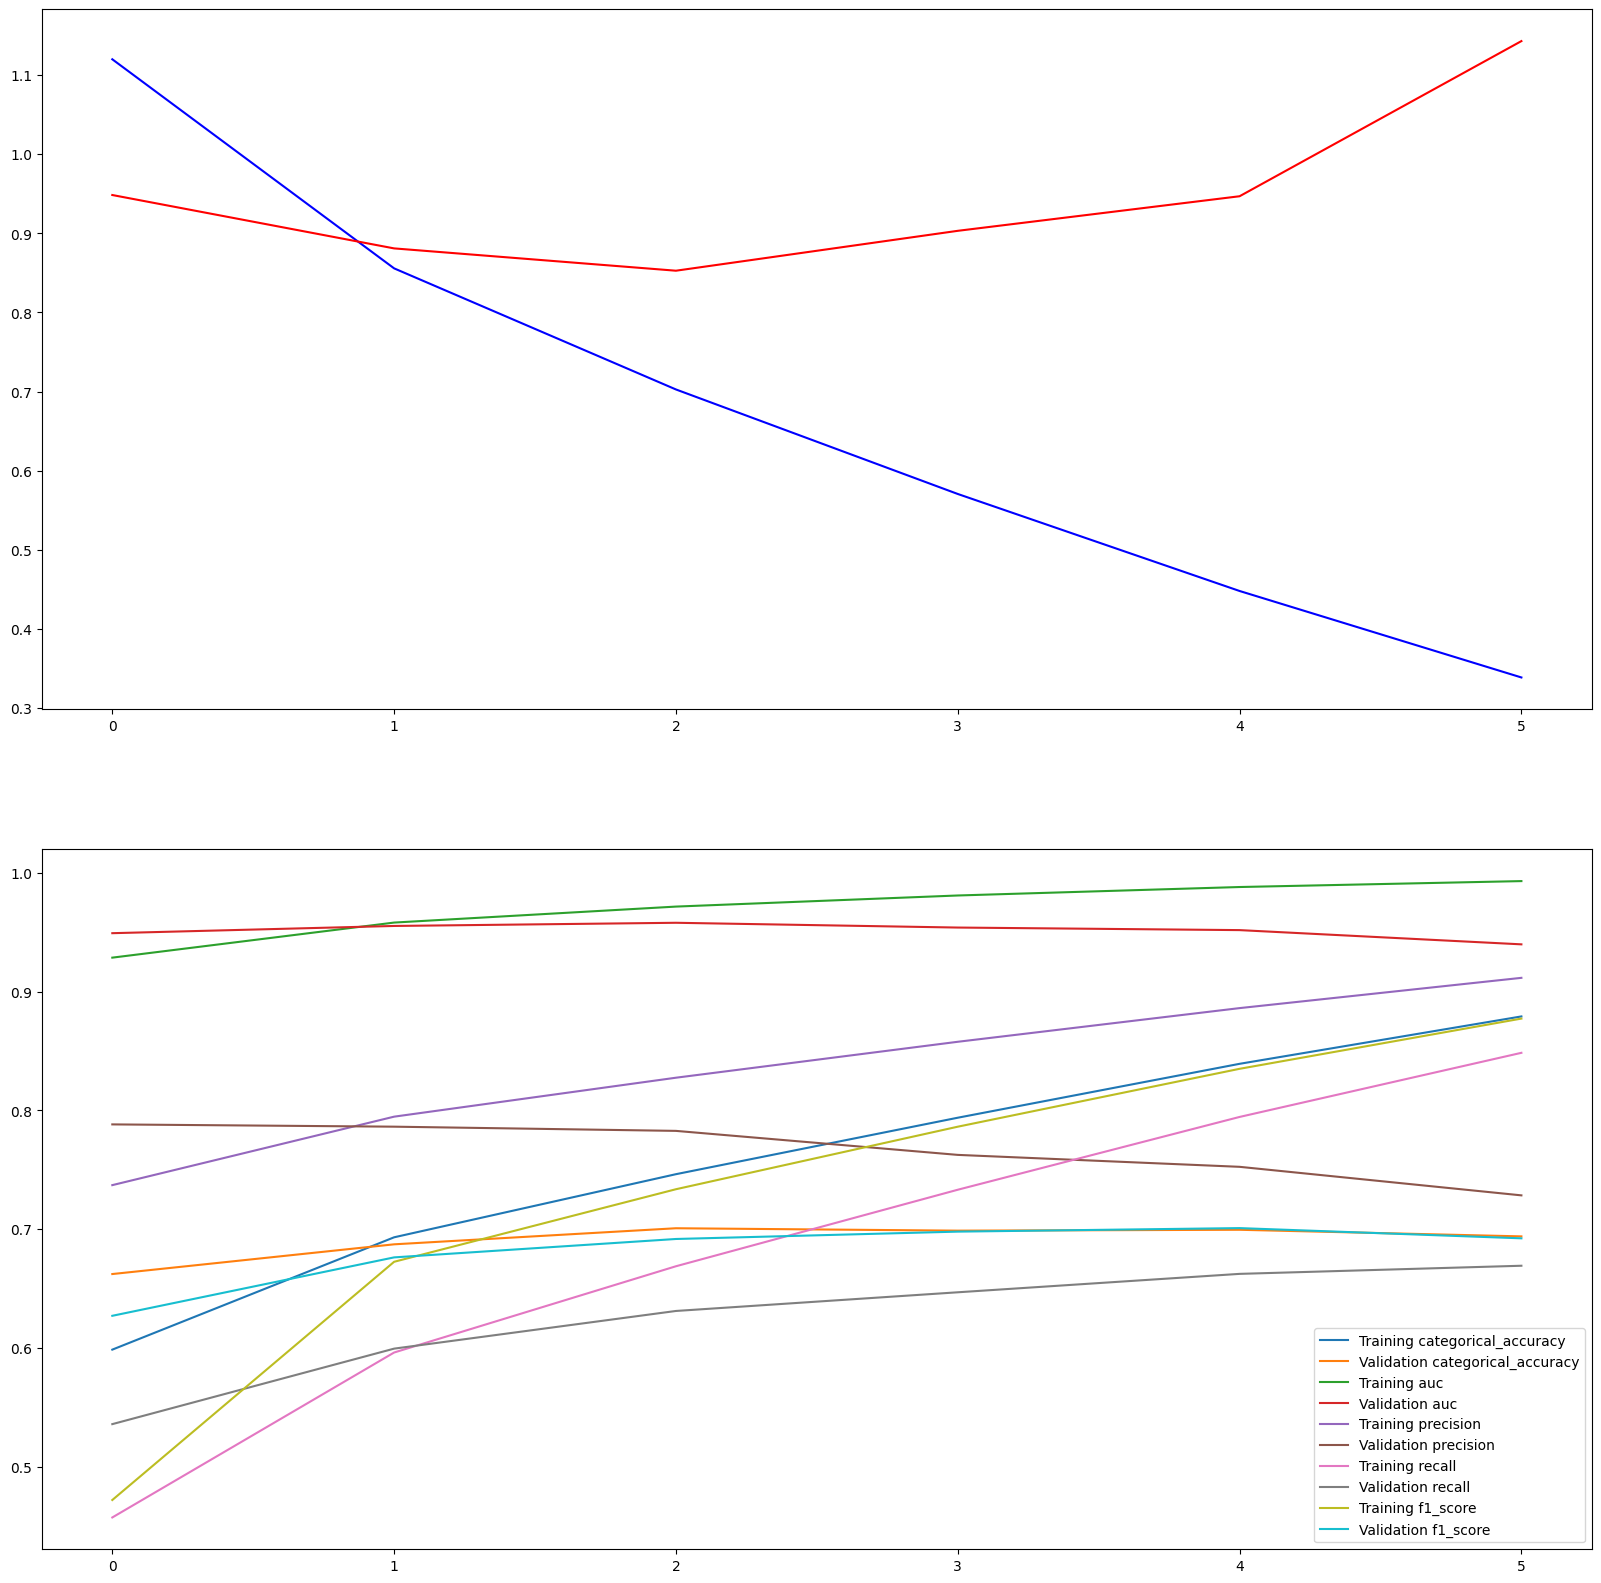

In [58]:
show_training_validation_loss_and_metrics(model,metrics2)

In [59]:
model.evaluate(test_ds)

5625/5625 [==============================] - 40s 7ms/step - loss: 1.1492 - categorical_accuracy: 0.6919 - auc: 0.9391 - precision: 0.7275 - recall: 0.6683 - f1_score: 0.6917


[1.1492482423782349,
 0.691944420337677,
 0.9391414523124695,
 0.7274541854858398,
 0.6682555675506592,
 0.6917234063148499]

5625/5625 [==============================] - 31s 5ms/step


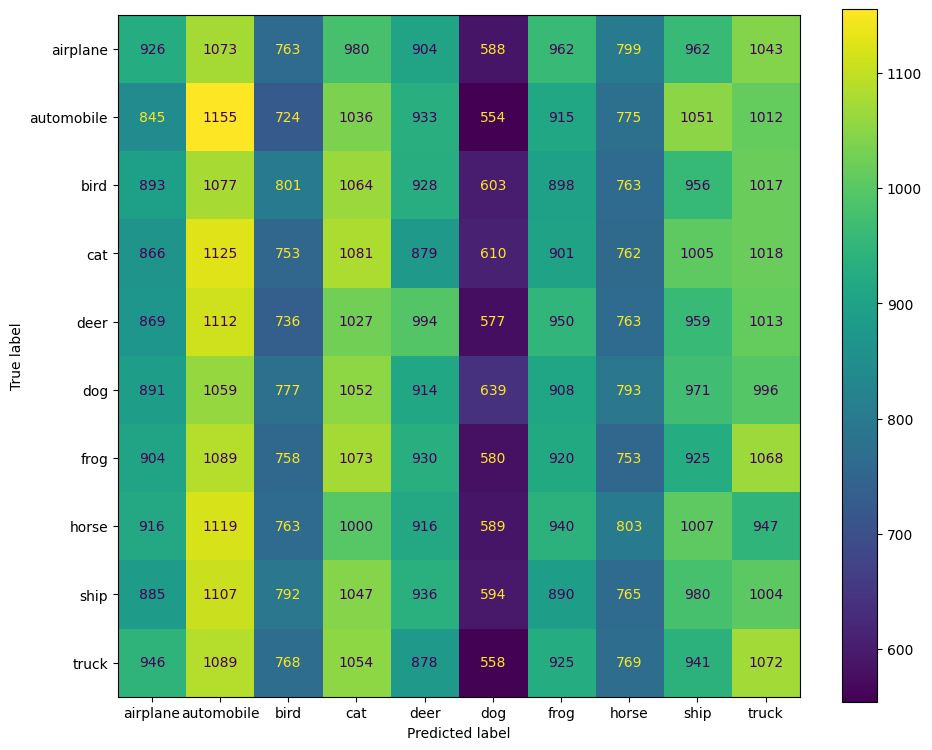

In [60]:
show_confusion_matrix(model,test_ds,num_classes,class_names)

5625/5625 [==============================] - 32s 6ms/step


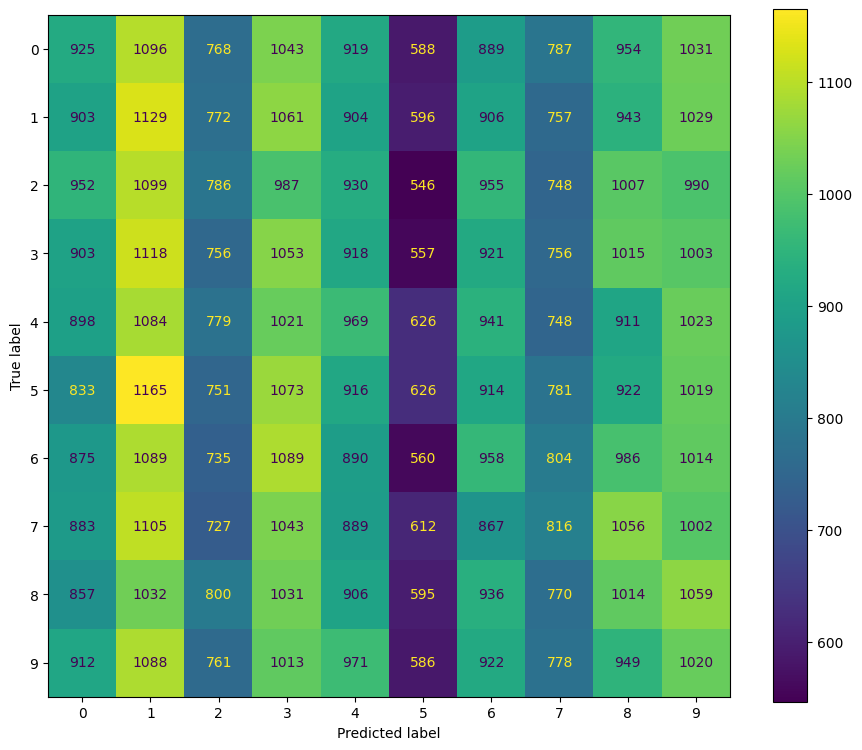

In [61]:
show_confusion_matrix_without_names(model,test_ds,num_classes)